<a href="https://ds4a-colombia.correlation1.com/"><img src = "https://ds4a-colombia-forum-dev.cor1.co/uploads/default/original/1X/29bfff1416aec51f9213c0800c7b15dc3fa07dd1.png" width = 250, align = "Right"></a>

# Weather Analytics - DS4A / Team 79

### Developed by:
####  Camilo Quiroga, Luis Dominguez, Leonardo Ramirez, Manuel Serrano, Daniel Mariño, Pascual Ferrans
    
***
<div class="alert alert-block alert-info" >
    
### Equipo aquí esta a groso modo la idea, sin embargo falta redactarla mejor

### Descripción:

Este Notebook tiene como objetivo analizar el comportamiento meteorológico de los aeropuertos más importantes de Colombia, teniendo en cuenta la información suministrada por
<a href="https://mesonet.agron.iastate.edu/ASOS/">IOWA State University - MESONET</a>. 

Para entender los fenómenos meteorológicos, se crearán mapas de calor espacio-temporales que permitan detectar patrones de las diferentes variables relacionadas con el clima. Para complementar el análisis, se utilizarán boxplots para entender la variabilidad de dichas variables por mes, hora y aeropuerto. Así mismo, se analizarán las tendencias de dichas variables meteorologicas para las últimas 12 horas, con el fin de entender su comportamiento y poder hacer pronosticos para la siguiente hora.

Por último, se utilizarán tecnicas de aprendizaje supervisado para hacer la predicción de las variables meteorologicas visibilidad horizontal y vertical, variables que generan mayores restricciones operacionales para las aerolineas en cada uno de los aeropuertos.

</div>


In [1]:
#!conda install folium -c conda-forge
#!conda install -c anaconda seaborn

In [2]:
import warnings; warnings.simplefilter('ignore')
import os, shutil, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium 
import seaborn as sns
import tensorflow as tf

from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
%matplotlib inline

### 1. Parametros

* **Countries (dictionary):** Listado de aeropuertos a analizar. 
* **Years (integer):** Cantidad de años de muestra para el análisis. Tenga en cuenta que aeropuertos de EU capturan información cada 10 min, mientras que en otras partes del mundo se captura cada hora
* **Save_heatmaps (Boolean):** Parametro que índica si se deben crear carpetas por aeropuertos para guardar el detalle de los gráficos de calor generados (Temperatura, Visibilidad, Tormenta, Lluvia, Restricción Operacional)
* **Save_summ (Boolean):** Parametro que índica si se crea un archivo de excel con el resumen de los análisis realizados

In [3]:
#Parameters

Countries={'CO':['ADZ','BAQ','BOG','BGA','CLO','CTG','CUC','LET','MDE','MTR','PEI','RCH','SMR','VUP']} 

Years=5
Save_heatmaps=False
Save_summ=False

### 2. Datos

* <a href="https://ourairports.com/data/">Airports data</a>
* <a href="https://mesonet.agron.iastate.edu/ASOS/">IOWA State University - MESONET</a>

In [4]:
#Airports Data Frame // Get data from our airports

airports=pd.read_csv("http://ourairports.com/data/airports.csv")
airports=airports[(airports["scheduled_service"]=='yes') & (airports["type"].str.contains("medium") | airports["type"].str.contains("large"))]
airports.drop(["id", "ident", "iso_region","continent","type","scheduled_service","local_code","home_link","wikipedia_link","keywords"],axis=1,inplace=True)

request=[]
for i in Countries:
    for j in Countries.get(i):
        request.append(j)
        
airports=airports[airports['iata_code'].isin(request)]
airports.set_index("iata_code",inplace=True)

kmeans = KMeans(n_clusters=3, random_state=0).fit(airports.iloc[:,1:4])
airports['Airport Type']=kmeans.labels_

In [5]:
airports

name  latitude_deg  \
iata_code                                                               
BGA                                   Palonegro Airport       7.12650   
BOG                     El Dorado International Airport       4.70159   
BAQ             Ernesto Cortissoz International Airport      10.88960   
CUC                   Camilo Daza International Airport       7.92757   
CTG                  Rafael Nuñez International Airport      10.44240   
CLO        Alfonso Bonilla Aragon International Airport       3.54322   
LET          Alfredo Vásquez Cobo International Airport      -4.19355   
MTR                                Los Garzones Airport       8.82374   
PEI                      Matecaña International Airport       4.81267   
MDE            Jose Maria Córdova International Airport       6.16454   
RCH                           Almirante Padilla Airport      11.52620   
SMR                 Simón Bolívar International Airport      11.11960   
ADZ         Gustavo Rojas Pinilla International Airport      12.58360   
VUP                      Alfonso López Pumarejo Airport      10.43500   

           longitude_deg  elevation_ft iso_country  municipality gps_code  \
iata_code                                                                   
BGA             -73.1848        3897.0          CO   Bucaramanga     SKBG   
BOG             -74.1469        8361.0          CO        Bogota     SKBO   
BAQ             -74.7808          98.0          CO  Barranquilla     SKBQ   
CUC             -72.5115        1096.0          CO        Cúcuta     SKCC   
CTG             -75.5130           4.0          CO     Cartagena     SKCG   
CLO             -76.3816        3162.0          CO          Cali     SKCL   
LET             -69.9432         277.0          CO       Leticia     SKLT   
MTR             -75.8258          36.0          CO      Montería     SKMR   
PEI             -75.7395        4416.0          CO       Pereira     SKPE   
MDE             -75.4231        6955.0          CO      Medellín     SKRG   
RCH             -72.9260          43.0          CO      Riohacha     SKRH   
SMR             -74.2306          22.0          CO   Santa Marta     SKSM   
ADZ             -81.7112          19.0          CO    San Andrés     SKSP   
VUP             -73.2495         483.0          CO    Valledupar     SKVP   

           Airport Type  
iata_code                
BGA                   2  
BOG                   1  
BAQ                   0  
CUC                   0  
CTG                   0  
CLO                   2  
LET                   0  
MTR                   0  
PEI                   2  
MDE                   1  
RCH                   0  
SMR                   0  
ADZ                   0  
VUP                   0

In [6]:
#Airports Visualization using folium

latitude=airports['latitude_deg'].median()
longitude=airports['longitude_deg'].median()
zoom=5

vivaair_map = folium.Map(location = [latitude, longitude], zoom_start = zoom)

for lat, lng, label in zip(list(airports.latitude_deg),list(airports.longitude_deg),list('('+airports.index+') '+airports.municipality)):
    folium.Marker([lat, lng], popup=label).add_to(vivaair_map) 

vivaair_map.save(outfile= "vivaair_map.html")
vivaair_map



In [7]:
minimos=pd.read_csv("Minimos requeridos Aeropuertos COL.csv",sep=';')
minimos.head()

IATA  H Vsby (miles)  V Vsby (ft) Approach
0  ADZ            1.43          500     GNSS
1  BAQ            0.62          200      ILS
2  BOG            0.50          220      ILS
3  BGA            0.81          300      ILS
4  CLO            0.50          283      ILS

In [8]:
minimos.set_index('IATA',inplace=True)
minimos=minimos.iloc[:,:-1]
minimos.head()

H Vsby (miles)  V Vsby (ft)
IATA                             
ADZ             1.43          500
BAQ             0.62          200
BOG             0.50          220
BGA             0.81          300
CLO             0.50          283

In [9]:
#Get data from IOWA State University - Mesonet
def getdata(stationslist,year=5,df=airports,adjUTC=-5):
    
    #stationlist: Listado de estaciones 
    if year<=0:
        year=1
    
    url="https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"

    for i in stationslist:
        url=url+"station="+str(df.at[i,'gps_code'])+"&"

    #Temperauture (°C)//Wind Speed (Knots)//Visibility (miles)
    #Cloud Coverage//Cloud Height Level (ft)//Present Wx Codes
    
    url=url+"data=tmpc&data=sknt&data=vsby&data=skyl1&data=wxcodes&"
    
    date2=datetime.datetime.utcnow().date() - datetime.timedelta(days=1)
    y2=str(date2.year)
    m2=str(date2.month)
    d2=str(date2.day)
    y1=str(date2.year-year)
    
    #Date from-to
    url=url+"&year1="+y1+"&month1=1&day1=1&year2="+y2+"&month2="+m2+"&day2="+d2
    
    #Missing valueas as null, download directly as txt fiile    
    url=url+"&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=null&trace=null&direct=yes&report_type=1&report_type=2"
    
    print(url)
        
    data=pd.read_csv(url)
    
    data["valid"]=pd.to_datetime(data["valid"])
    data["Year"]= pd.DatetimeIndex(data["valid"]).year
    data["Month"]= pd.DatetimeIndex(data["valid"]).month
    data["Day"]= pd.DatetimeIndex(data["valid"]+datetime.timedelta(hours=adjUTC)).day
    #data["Hour UTC"]= pd.DatetimeIndex(data["valid"]).hour
    data["Hour"]= pd.DatetimeIndex(data["valid"]+datetime.timedelta(hours=adjUTC)).hour
    data["valid"]=pd.DatetimeIndex(data["valid"]+datetime.timedelta(hours=adjUTC))
    
    data["Rain"]=data['wxcodes'].str.contains('RA').fillna(False).astype(int)*100

    data["Fog-Brume"]=(data['wxcodes'].str.contains('FG')|data['wxcodes'].str.contains('BR')|(data['wxcodes'].str.contains('HZ'))).fillna(False).astype(int)*100
    data["Thunder"]=data['wxcodes'].str.contains('TS').fillna(False).astype(int)*100
    data["Op constraint"]=((data["Fog-Brume"]==100) | (data["Thunder"]==100)).astype(int)*100
    data.rename(columns={"station":"OACI","tmpc": "Temperature","vsby":"H Vsby","skyl1":"V Vsby","sknt": "Wind"},inplace=True)
        
    df2=df['gps_code'].to_frame().reset_index()
    data=pd.merge(left=data, right=df2, how='left', left_on='OACI', right_on='gps_code')
    
    data.rename(columns={"iata_code":"IATA","valid":"Date"},inplace=True)
    data['IATA']=data['IATA'].fillna(data['OACI'])
        
    data=data[['IATA','OACI',"Date",'Year','Month','Day', 'Hour', 'H Vsby', 'V Vsby','Temperature', 
               'Wind', 'Rain', 'Fog-Brume', 'Thunder','Op constraint']]
    
    data.sort_values(by=['IATA','Year','Month','Day', 'Hour'],inplace=True)
    
    data.reset_index(drop=True,inplace=True)
    return data
    

In [10]:
#Solicitud de información histórica
data=getdata(request,year=5)
data

https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=SKSP&station=SKBQ&station=SKBO&station=SKBG&station=SKCL&station=SKCG&station=SKCC&station=SKLT&station=SKRG&station=SKMR&station=SKPE&station=SKRH&station=SKSM&station=SKVP&data=tmpc&data=sknt&data=vsby&data=skyl1&data=wxcodes&&year1=2015&month1=1&day1=1&year2=2020&month2=10&day2=30&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=null&trace=null&direct=yes&report_type=1&report_type=2


IATA  OACI                Date  Year  Month  Day  Hour  H Vsby  V Vsby  \
0       ADZ  SKSP 2015-01-01 00:00:00  2015      1    1     0    6.21  1700.0   
1       ADZ  SKSP 2015-01-01 01:00:00  2015      1    1     1    6.21  1700.0   
2       ADZ  SKSP 2015-01-01 02:00:00  2015      1    1     2    6.21  1700.0   
3       ADZ  SKSP 2015-01-01 03:00:00  2015      1    1     3    6.21  1700.0   
4       ADZ  SKSP 2015-01-01 04:00:00  2015      1    1     4    6.21  1700.0   
...     ...   ...                 ...   ...    ...  ...   ...     ...     ...   
605697  VUP  SKVP 2020-09-30 09:00:00  2020      9   30     9    6.21  1000.0   
605698  VUP  SKVP 2020-09-30 10:00:00  2020      9   30    10    6.21  1000.0   
605699  VUP  SKVP 2020-09-30 11:00:00  2020      9   30    11    6.21  1500.0   
605700  VUP  SKVP 2020-09-30 13:00:00  2020      9   30    13    6.21  1500.0   
605701  VUP  SKVP 2020-09-30 14:00:00  2020      9   30    14    6.21  1500.0   

        Temperature  Wind  Rain  Fog-Brume  Thunder  Op constraint  
0              27.0   9.0     0          0        0              0  
1              27.0   9.0     0          0        0              0  
2              27.0   8.0     0          0        0              0  
3              27.0   8.0     0          0        0              0  
4              27.0   8.0     0          0        0              0  
...             ...   ...   ...        ...      ...            ...  
605697         26.0   6.0     0          0        0              0  
605698         29.0   7.0     0          0        0              0  
605699         28.0   8.0     0          0        0              0  
605700         31.0   7.0     0          0        0              0  
605701         31.0   8.0     0          0        0              0  

[605702 rows x 15 columns]

In [11]:
data[['IATA','Date']].groupby(['IATA'])['Date'].max().to_frame()

Date
IATA                    
ADZ  2020-10-29 17:00:00
BAQ  2020-10-29 17:00:00
BGA  2020-10-29 18:00:00
BOG  2020-10-29 18:00:00
CLO  2020-10-29 18:00:00
CTG  2020-10-29 17:00:00
CUC  2020-10-29 17:00:00
LET  2020-10-29 18:00:00
MDE  2020-10-29 17:00:00
MTR  2020-09-30 14:00:00
PEI  2020-10-29 18:00:00
RCH  2020-09-30 14:00:00
SMR  2020-10-28 17:00:00
VUP  2020-09-30 14:00:00

In [12]:
#El archivo no se actualiza hora a hora,
#hay un desfase de 2 días, por lo tanto no se puede hacer un gráfico 
#de tendencia hora a hora si no boxplots de la información pasada de ese mes por hora
#Ademas el último reporte de los aeropuertos no es a la misma hora

In [13]:
from datetime import date

#Creación de directorios para guardar las imagenes de acuerdo a la fecha de consulta

if Save_heatmaps==True or Save_heatmaps==True:
    dir = os.getcwd()+"/"+ str(date.today().strftime("%y%m%d"))+" Airport Heatmaps"

    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)
    
print(dir)

<built-in function dir>


In [14]:
#Se crearán subgrupos de las variables meteorologicas por aeropuerto, hora y mes para así graficar los mapas de calor

dataframes={}
group={}
columns=['Temperature','Wind','Rain','Fog-Brume','Thunder','Op constraint']
columns_title=['Temperature (°C)','Wind (knots)','% Rain','% Fog-Brume','% Thunder','% Op constraint']
hour=['Hour']

cont=0

for i in request:
    for j in hour:
        for k in columns:
            dataframes[(i,j,k)]=data[['IATA','Month',j,k]][data[['IATA','Month',j,k]]['IATA']==i]
            group[(i,j,k)]= round(dataframes.get((i,j,k)).groupby(['Month',j]).mean().unstack().fillna(0).T,0)
            
            if k=='Fog-Brume':
                if cont==0:
                    Fog=round(dataframes[(i,j,k)].groupby(['IATA','Month',j]).mean().reset_index(),0)
                    cont+=1
                else:
                    Fog=pd.concat([Fog,round(dataframes[(i,j,k)].groupby(['IATA','Month',j]).mean().reset_index(),0)])

Fog=Fog.reset_index(drop=True)
Fog.rename(columns={'Fog-Brume':'% Fog Occurence'}, inplace=True)
Fog

IATA  Month  Hour  % Fog Occurence
0     ADZ      1     0              0.0
1     ADZ      1     1              1.0
2     ADZ      1     2              0.0
3     ADZ      1     3              0.0
4     ADZ      1     4              0.0
...   ...    ...   ...              ...
3775  VUP     12    19              0.0
3776  VUP     12    20              0.0
3777  VUP     12    21              0.0
3778  VUP     12    22              0.0
3779  VUP     12    23              0.0

[3780 rows x 4 columns]

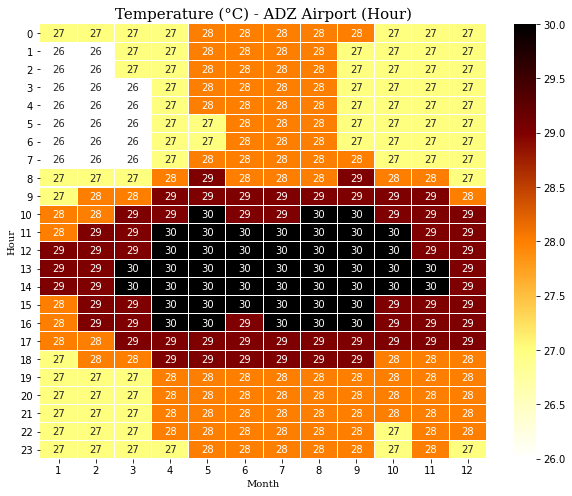

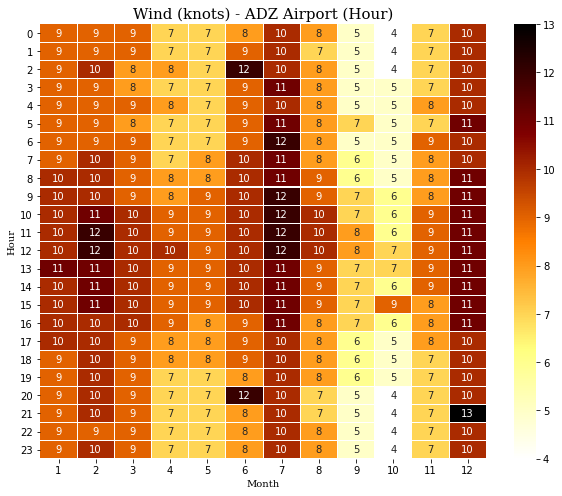

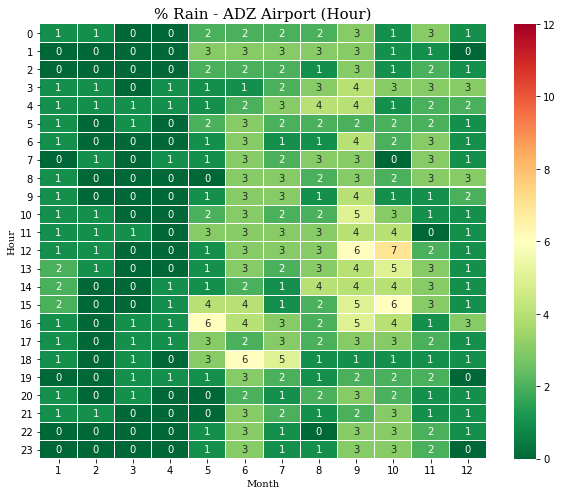

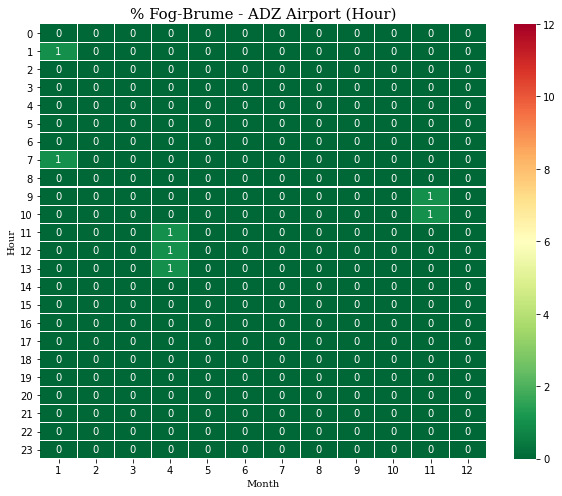

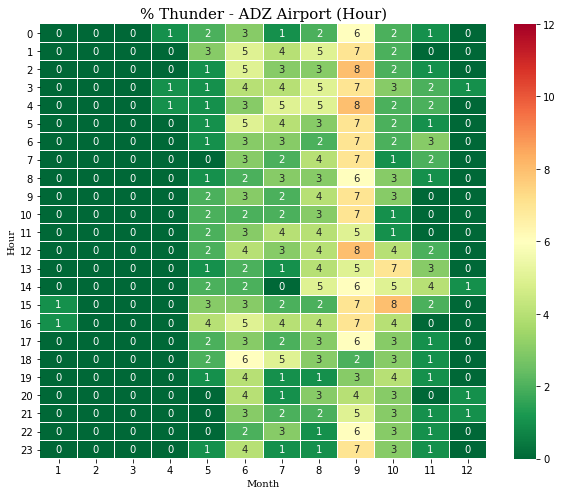

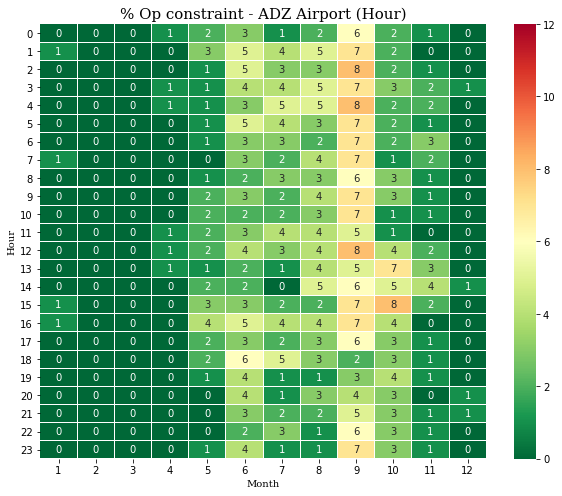

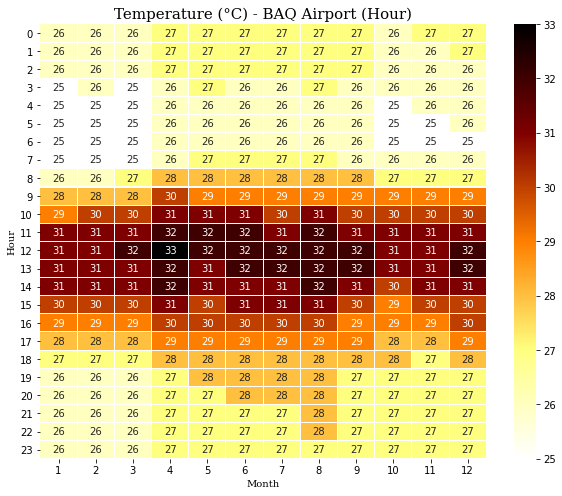

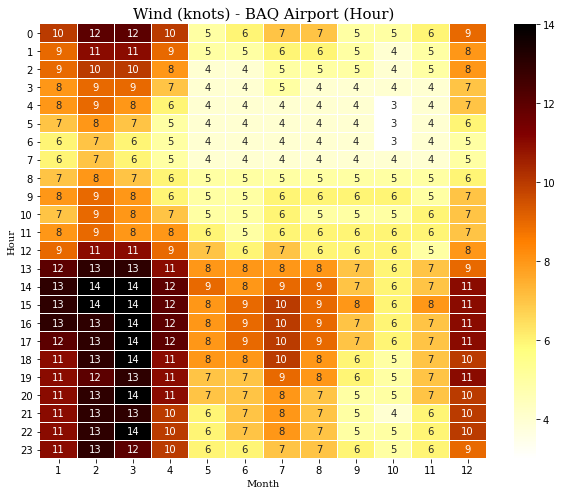

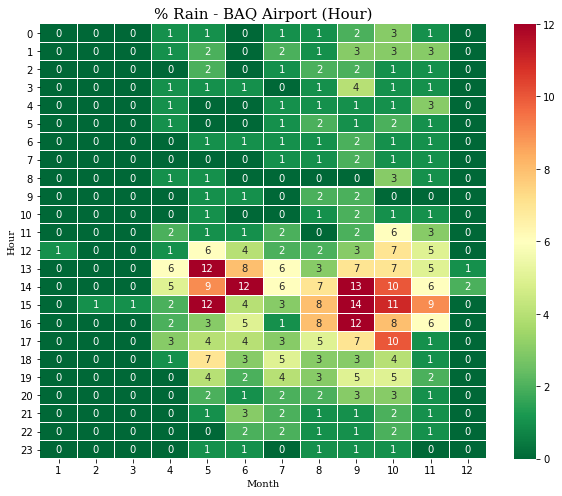

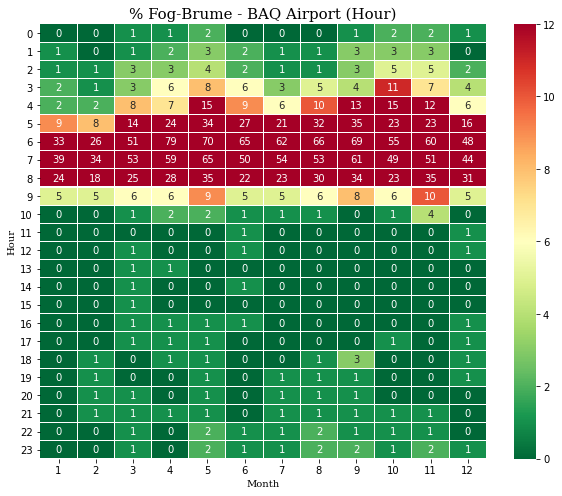

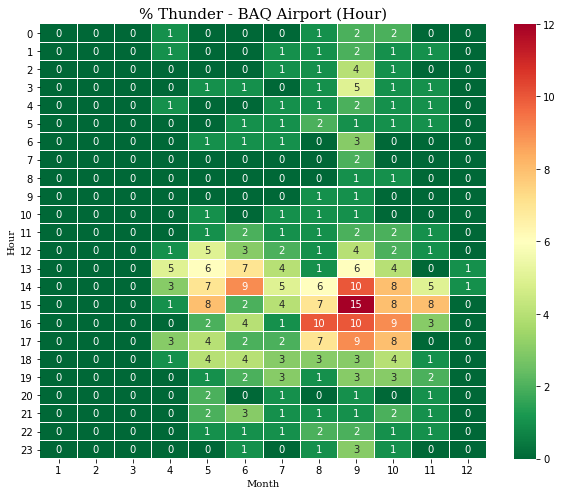

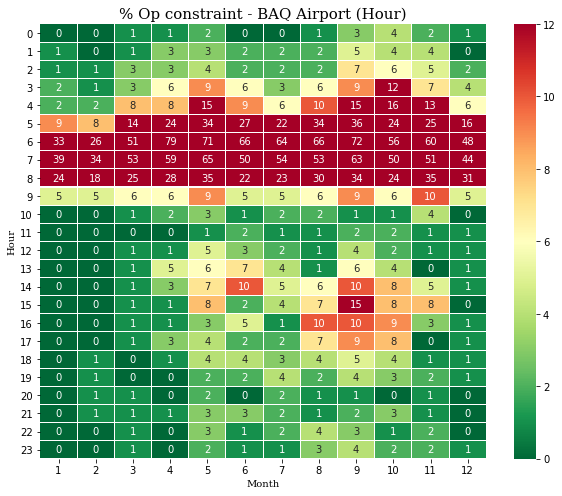

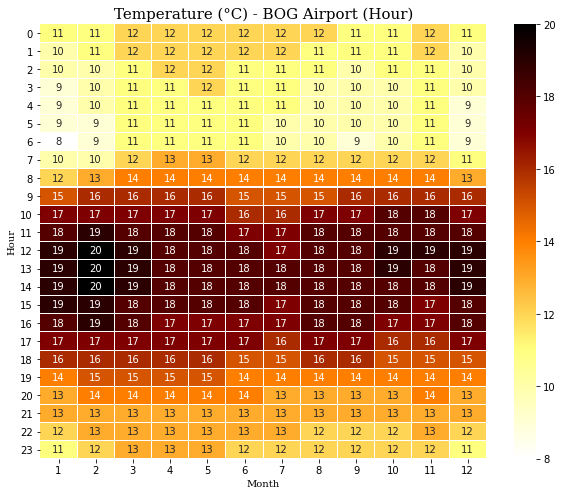

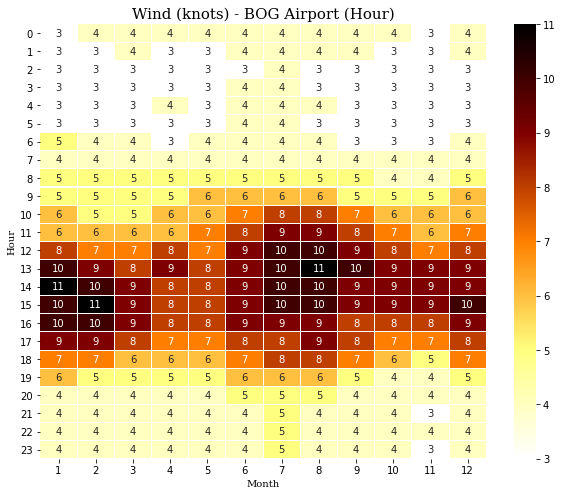

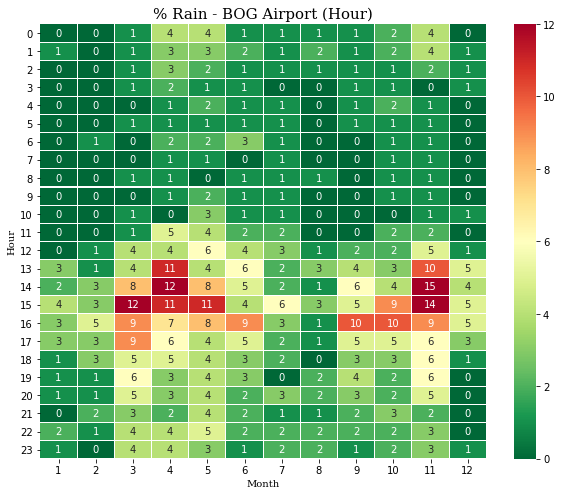

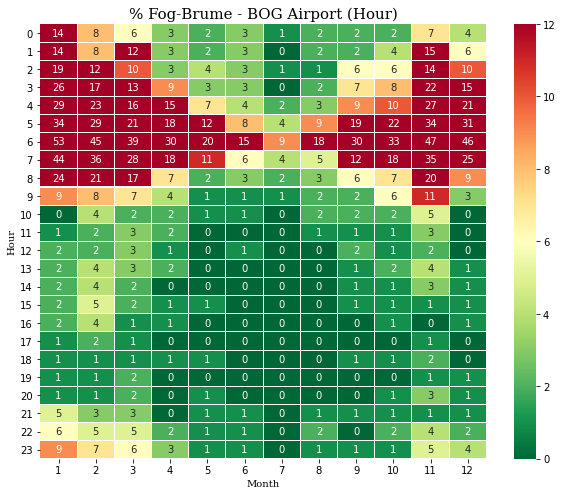

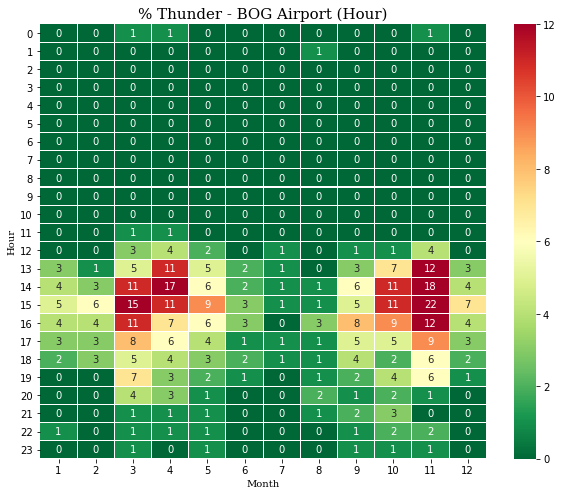

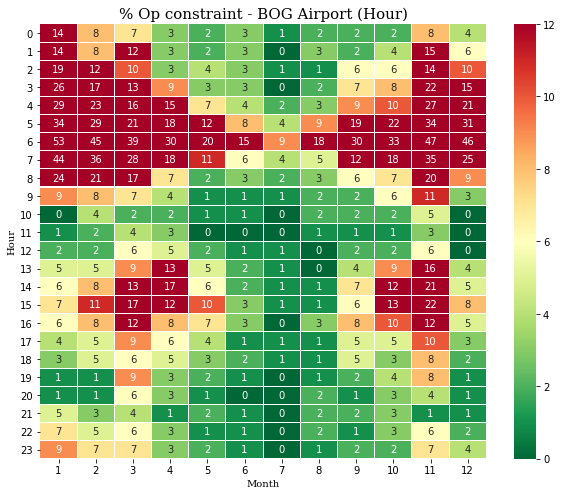

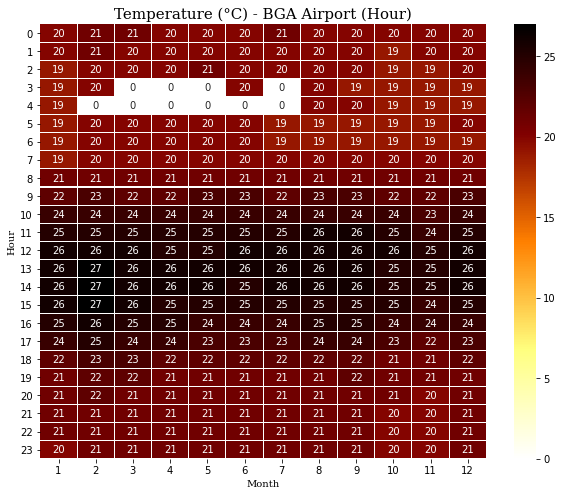

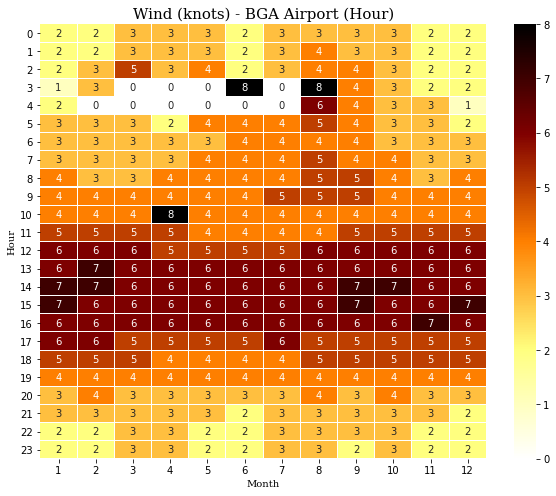

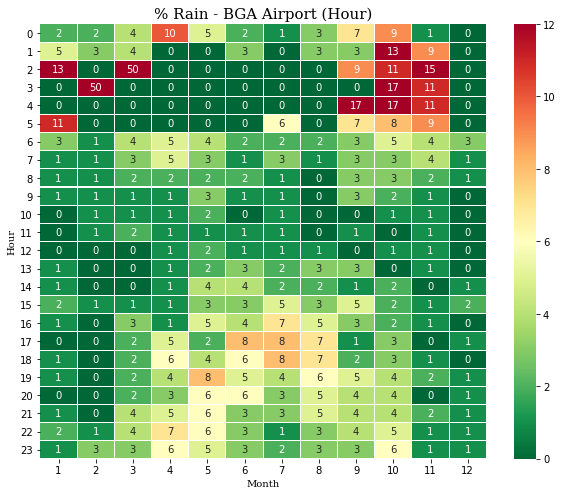

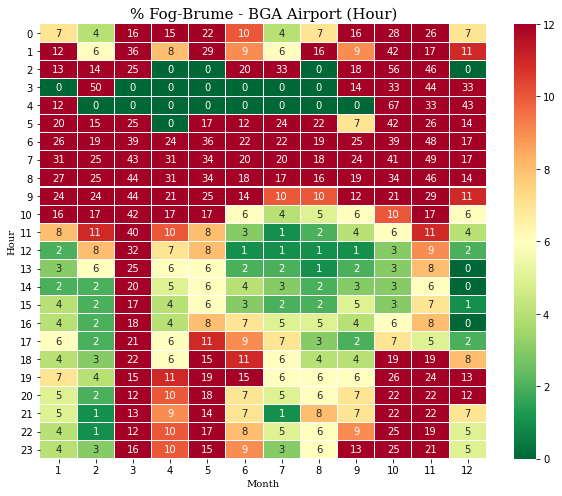

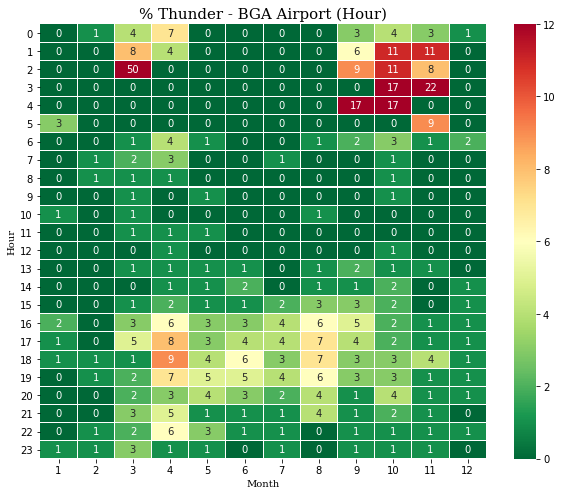

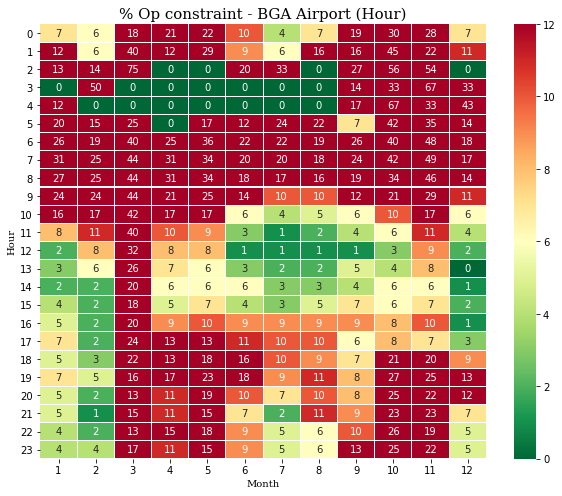

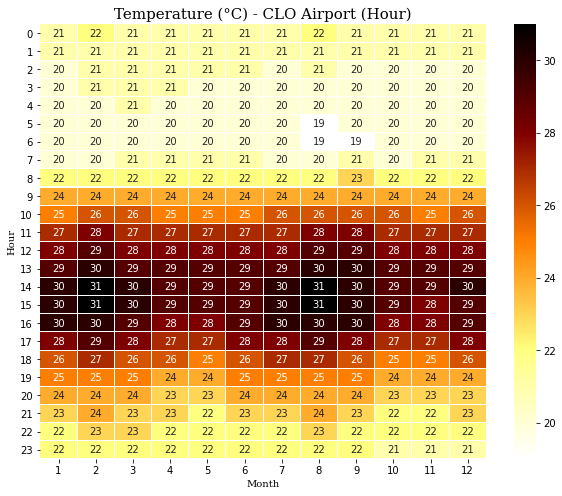

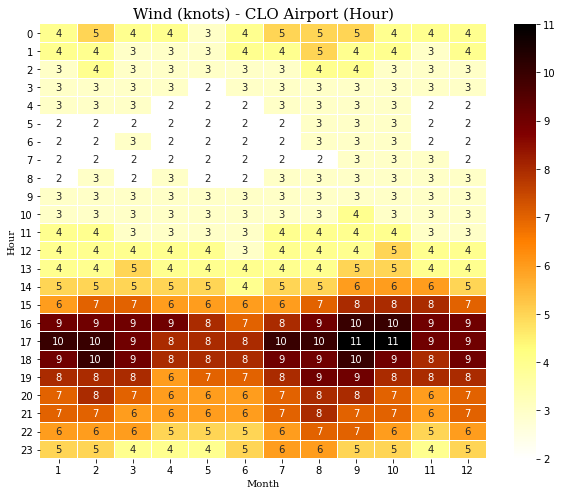

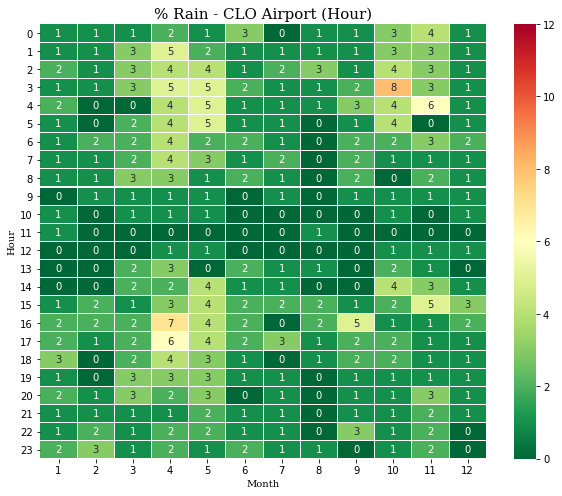

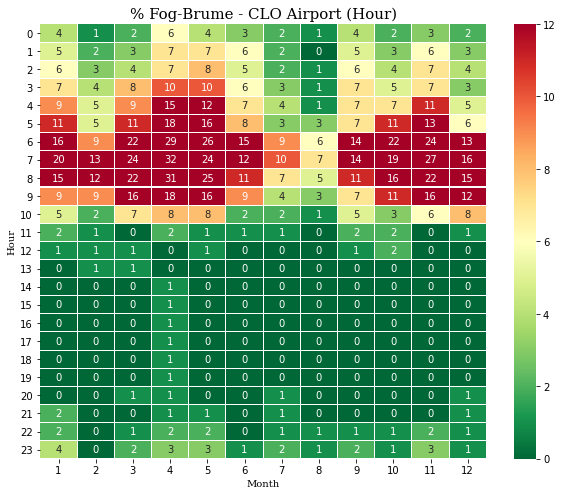

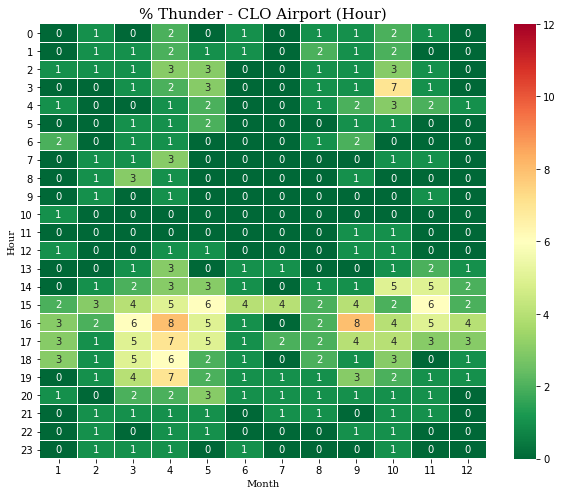

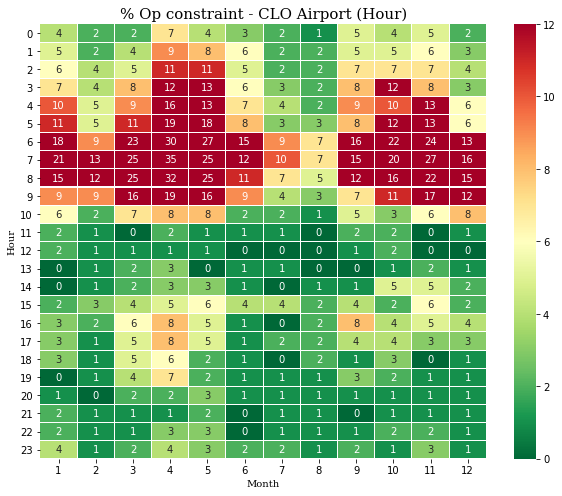

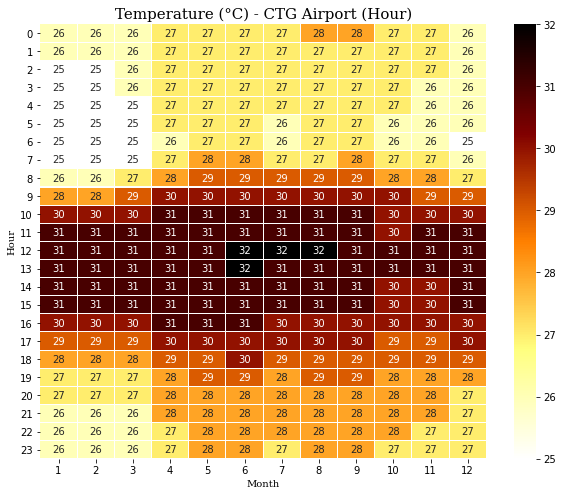

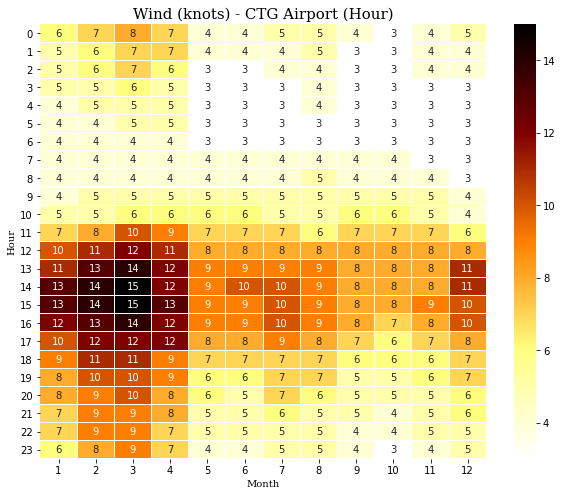

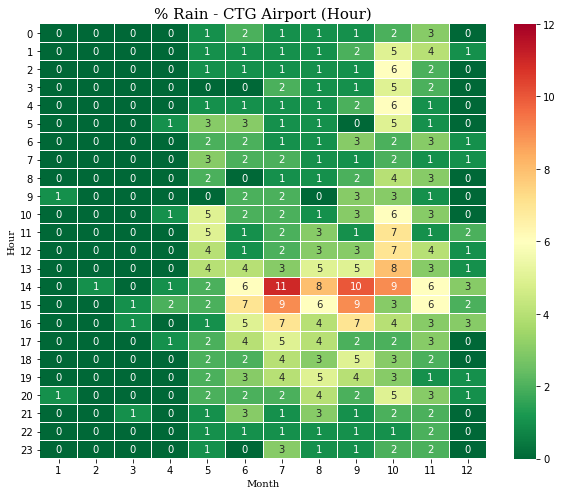

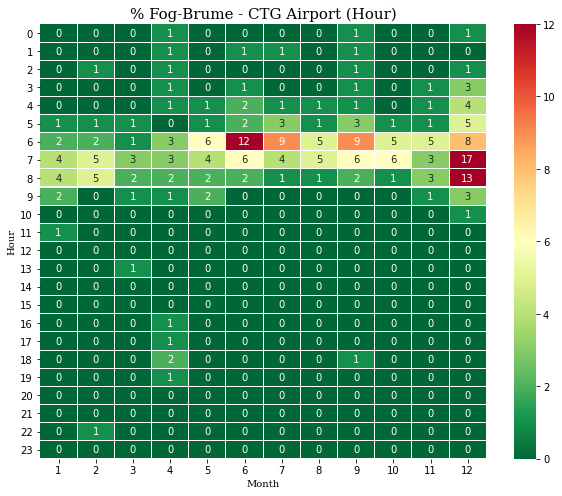

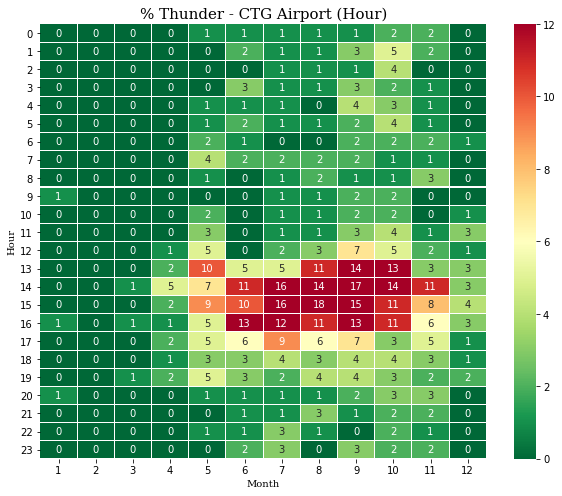

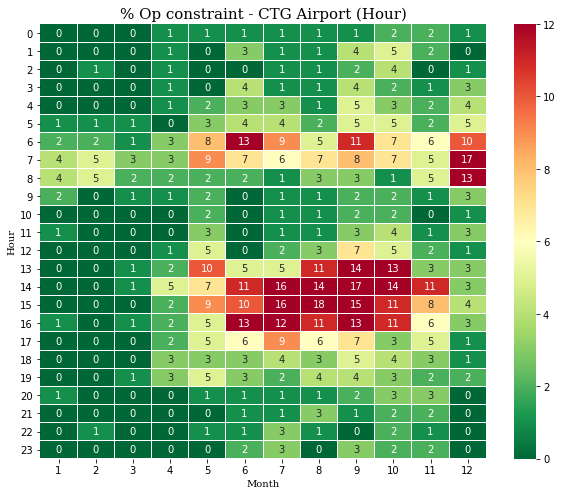

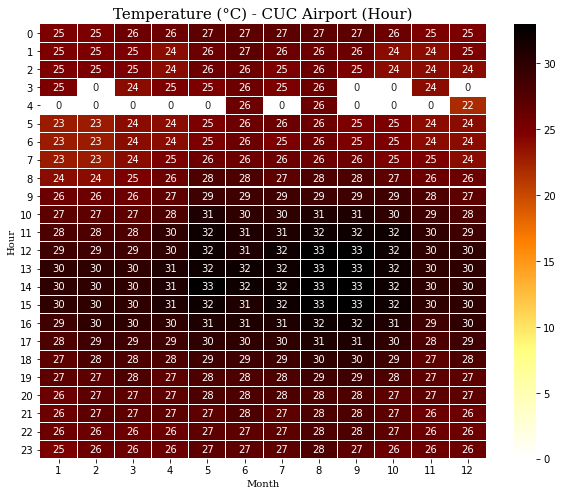

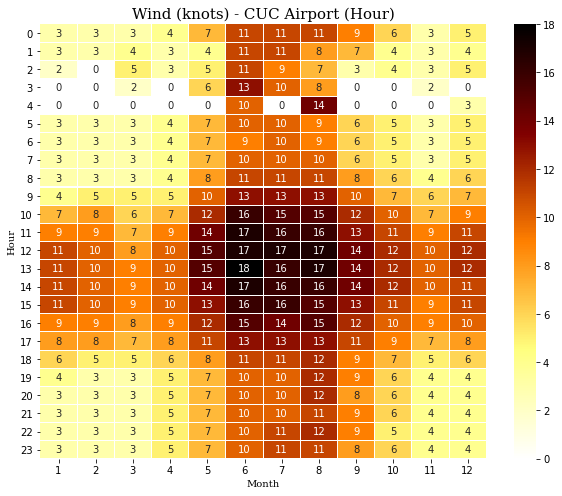

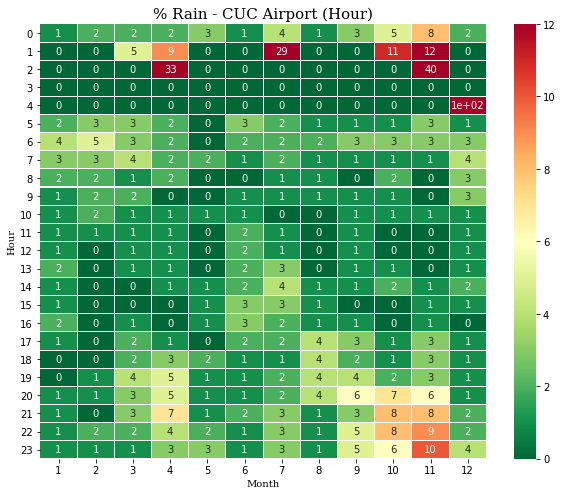

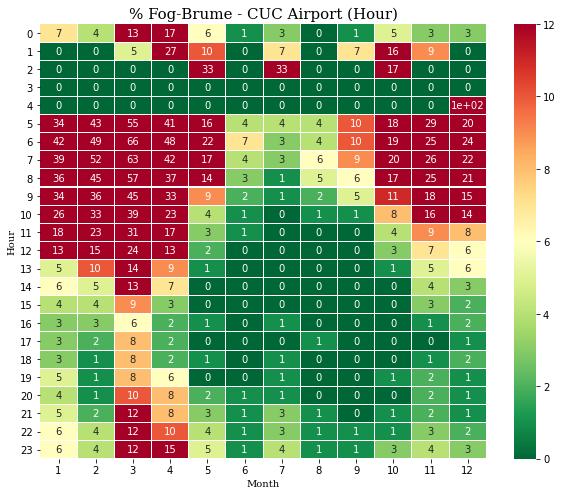

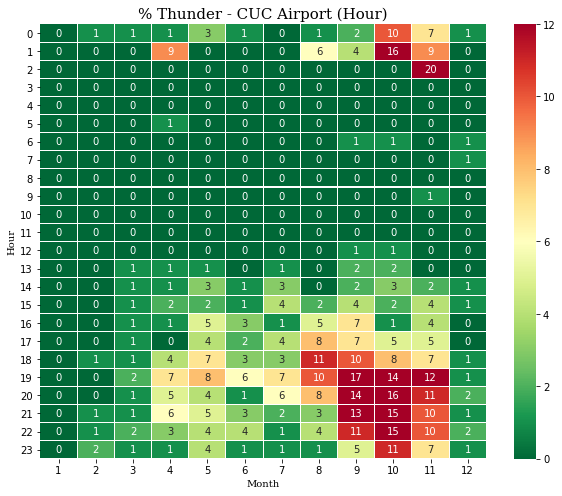

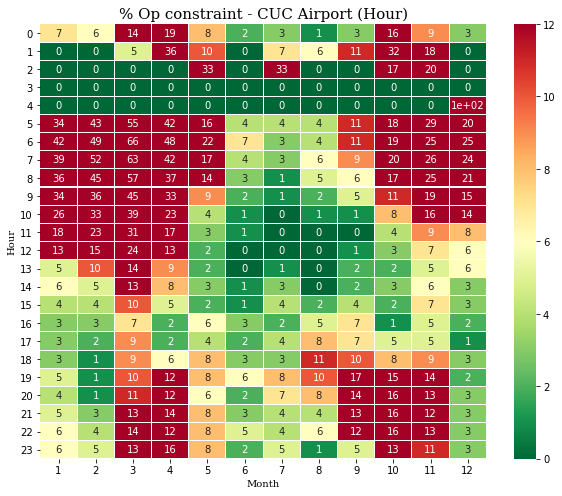

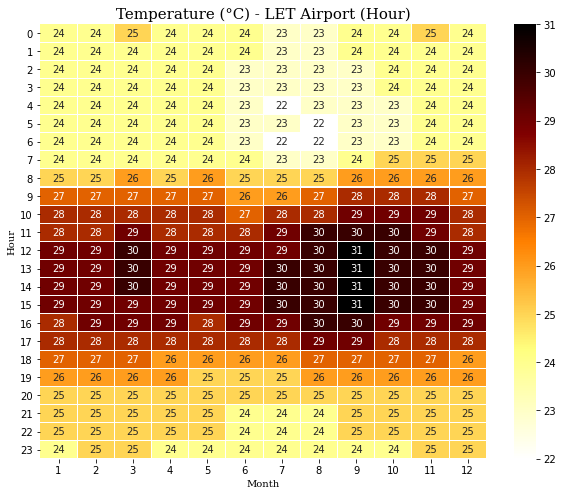

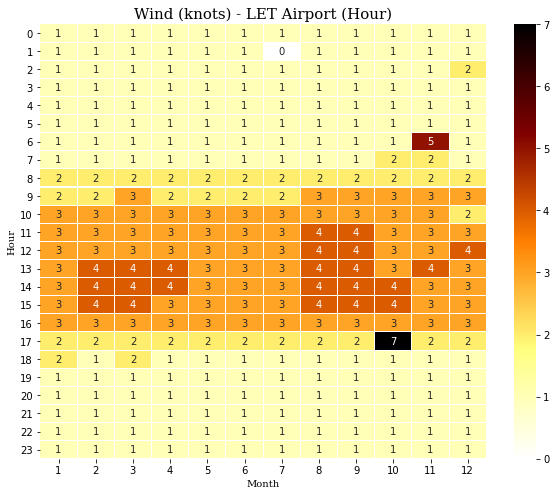

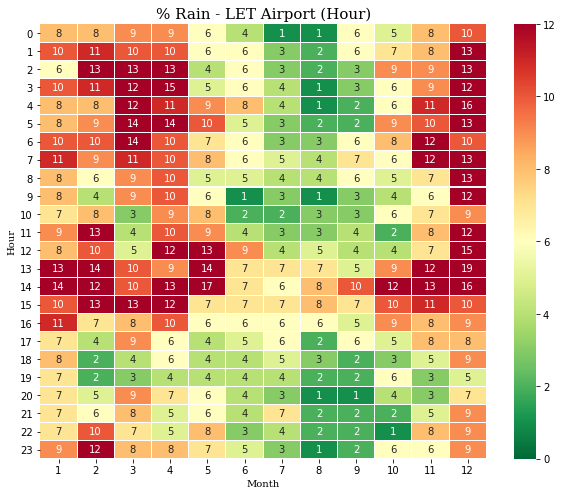

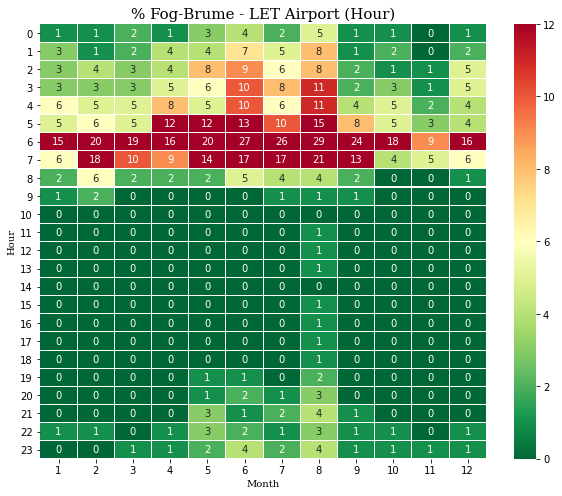

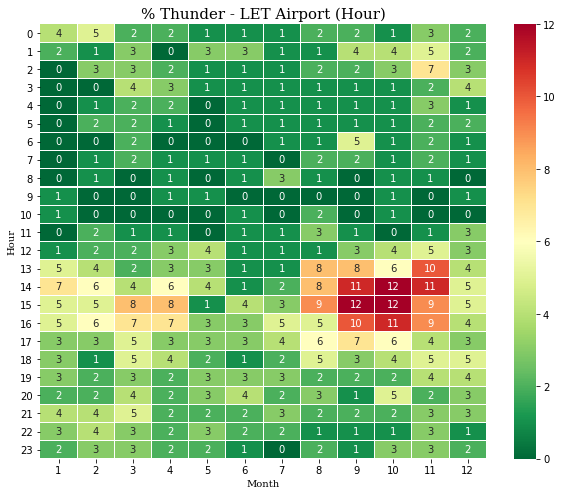

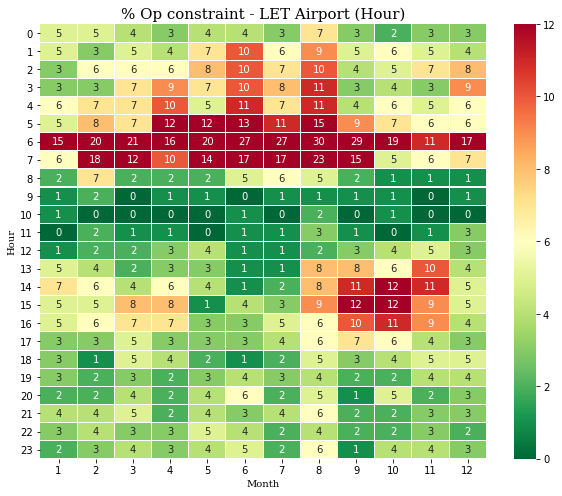

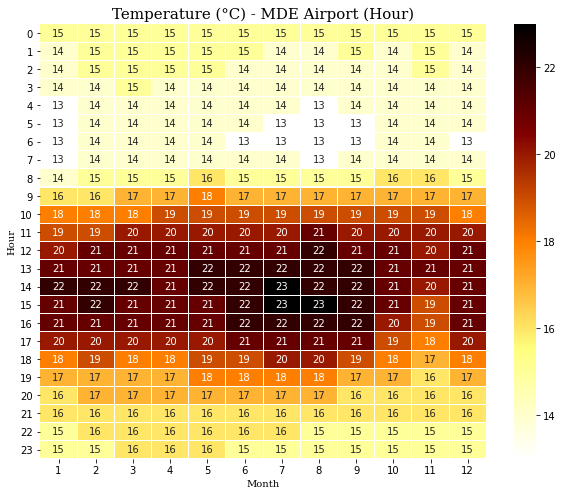

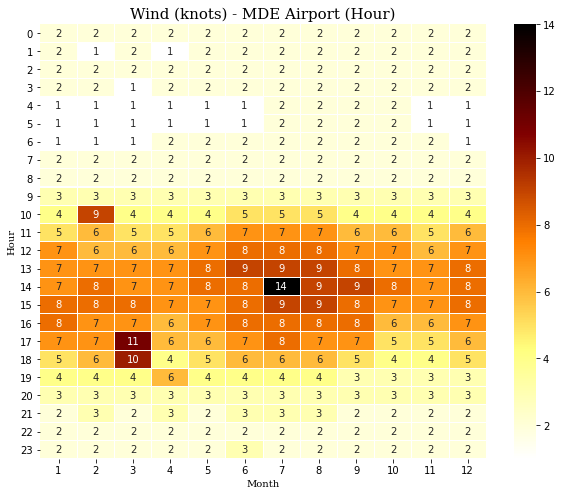

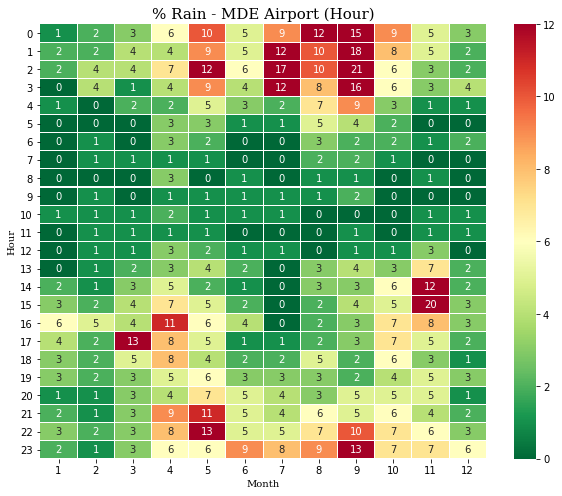

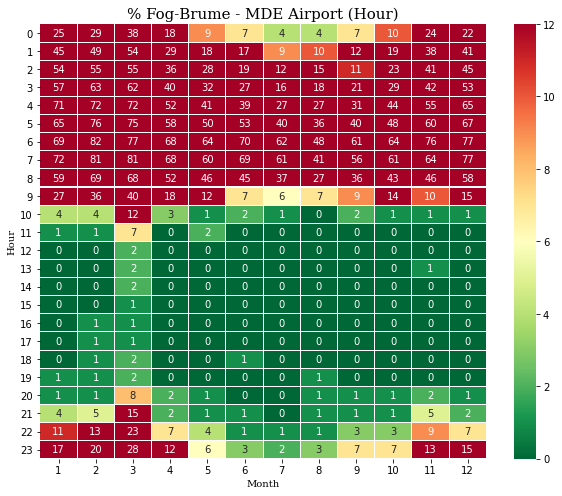

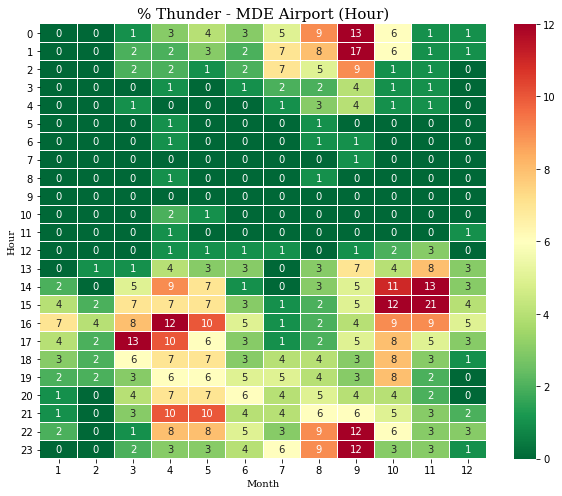

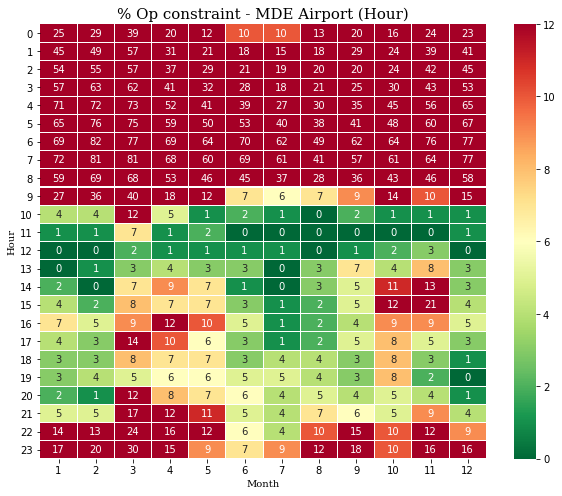

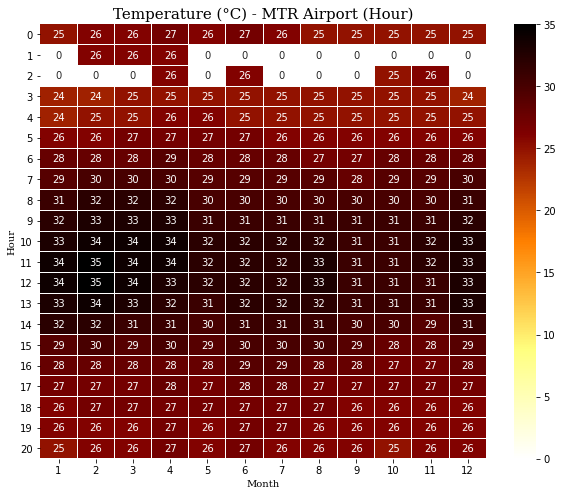

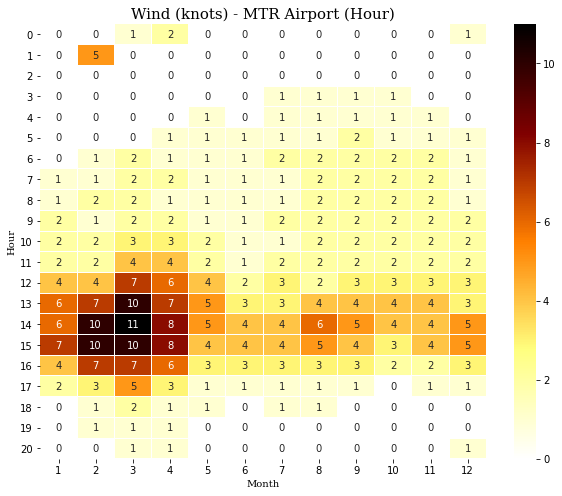

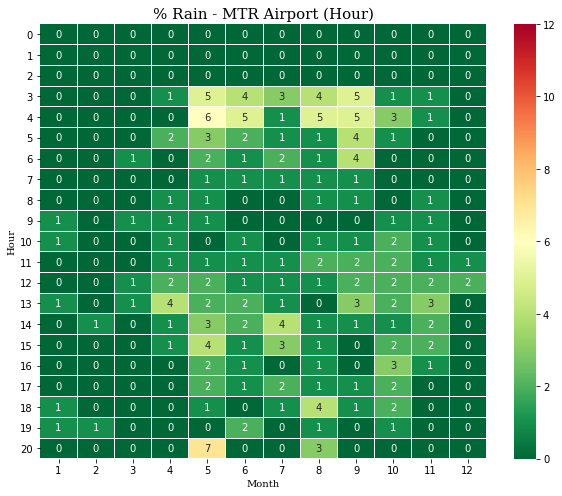

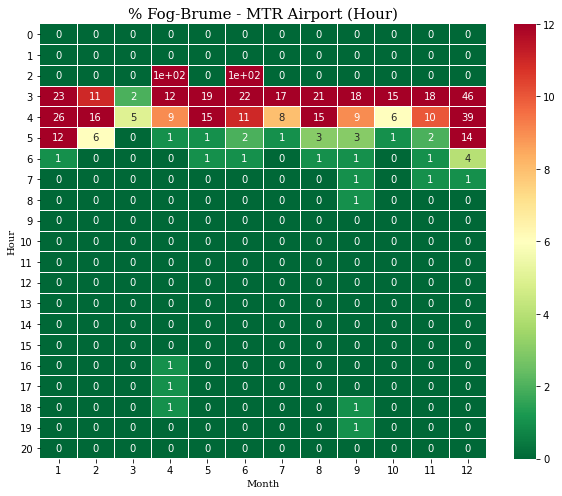

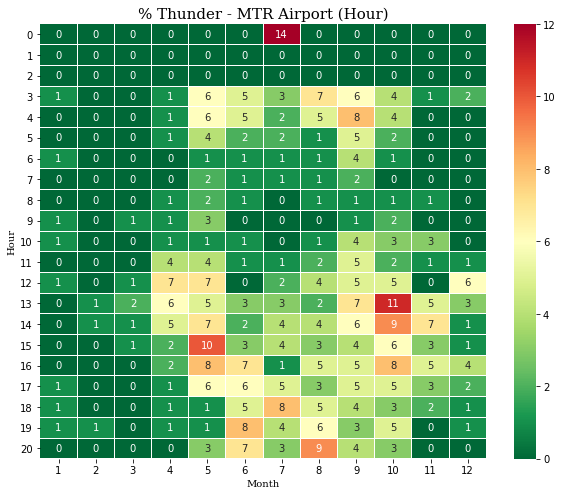

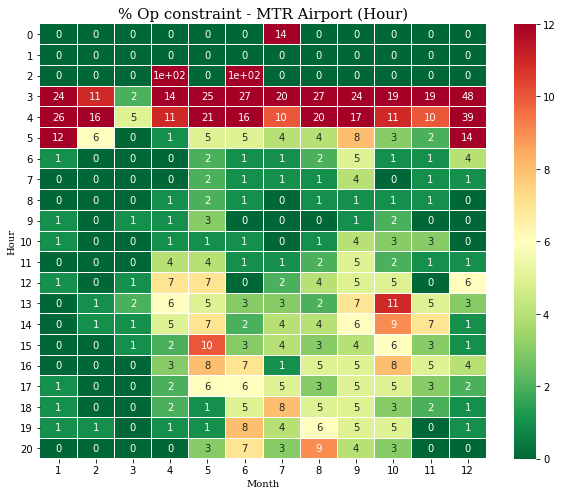

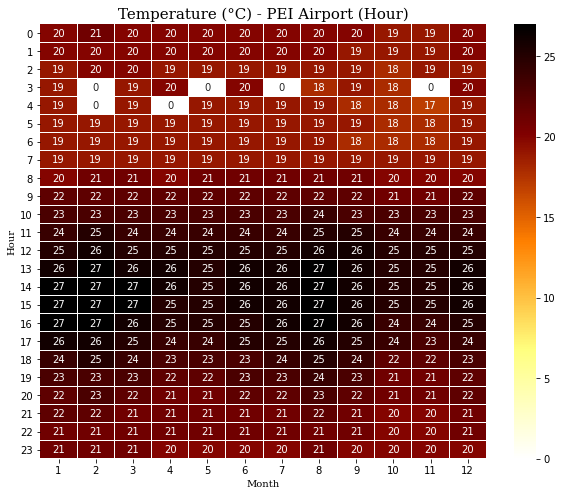

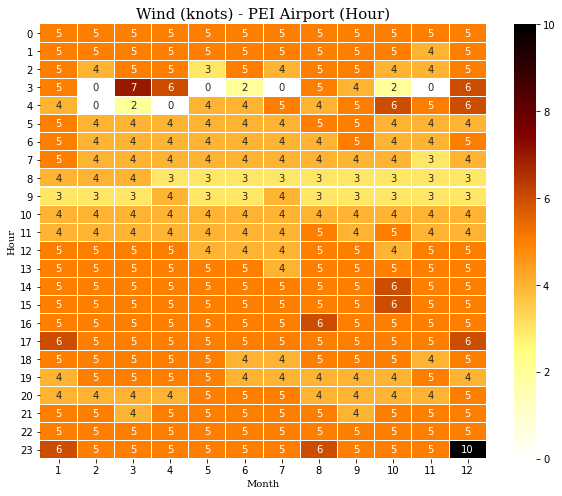

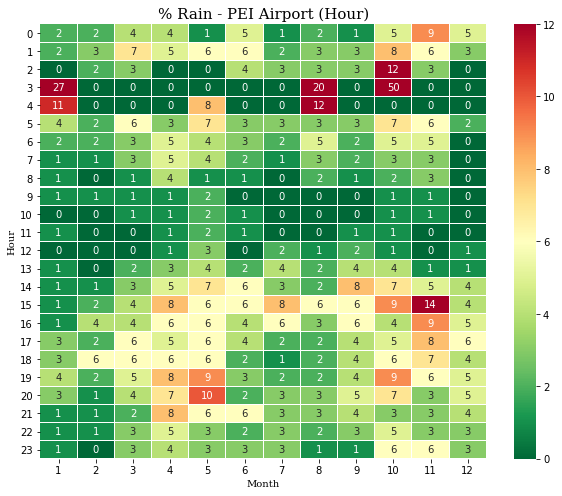

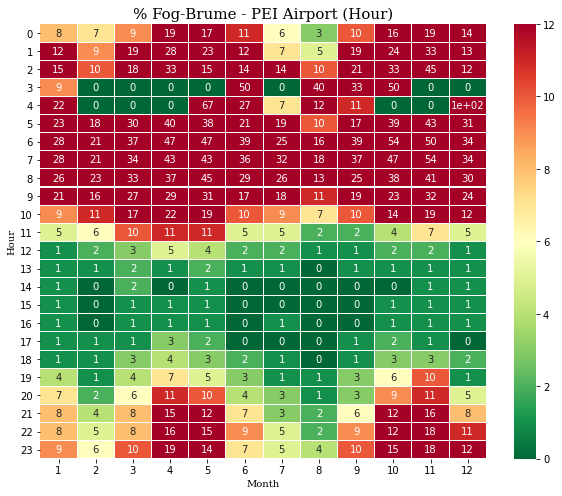

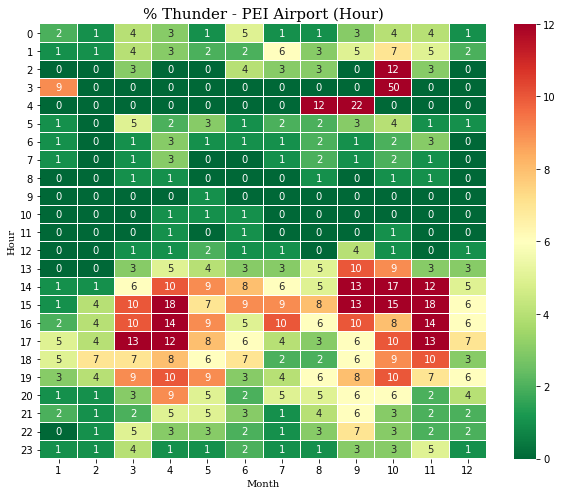

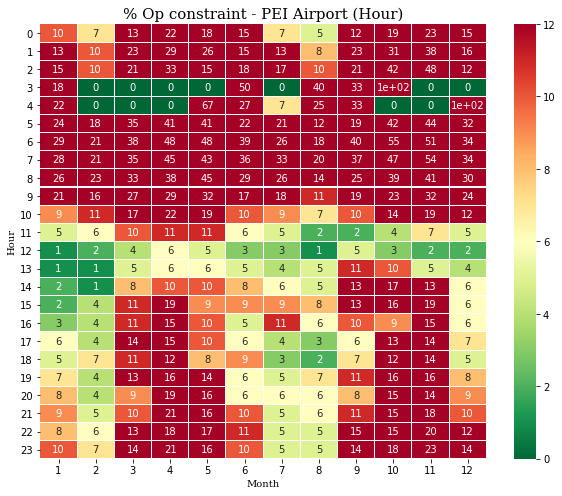

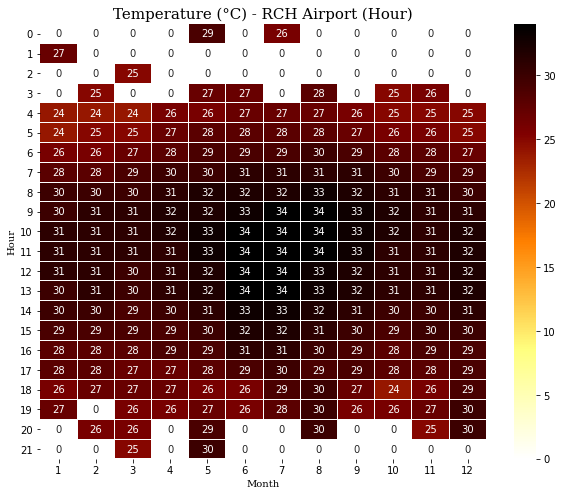

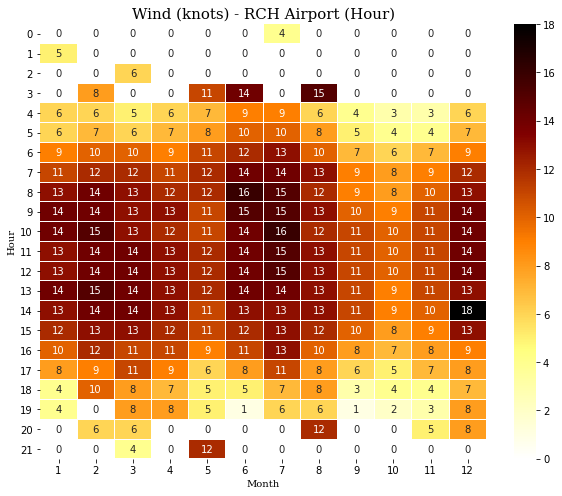

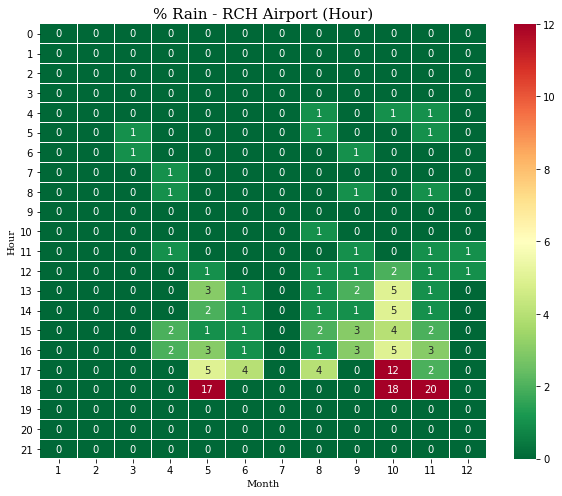

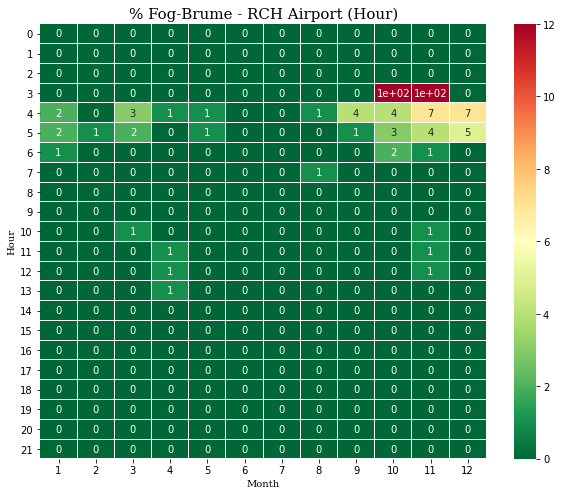

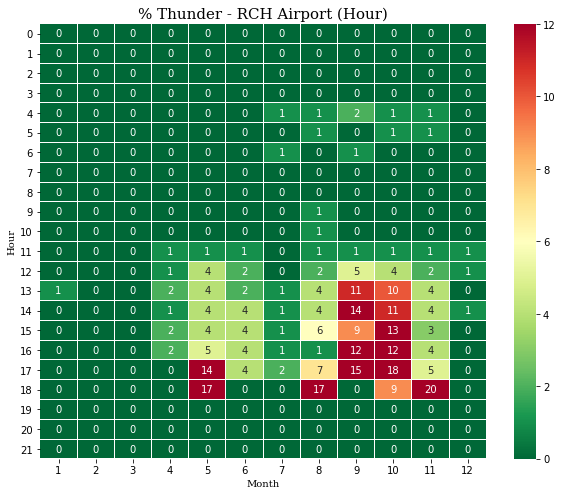

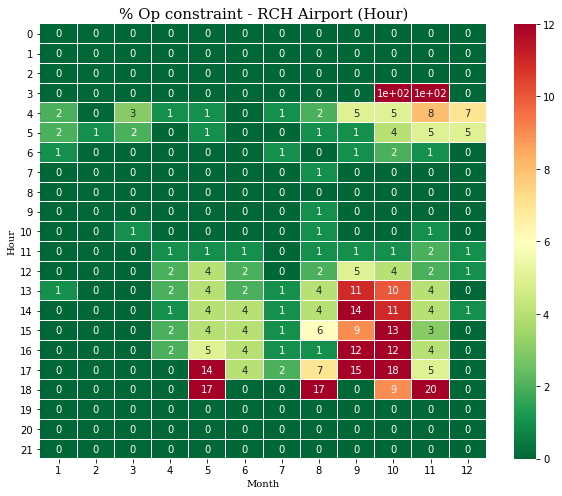

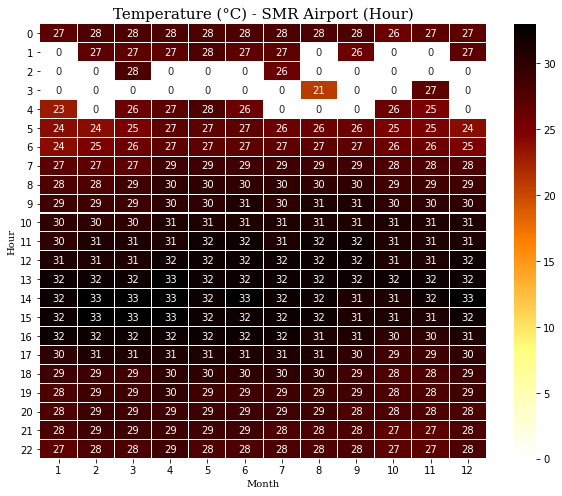

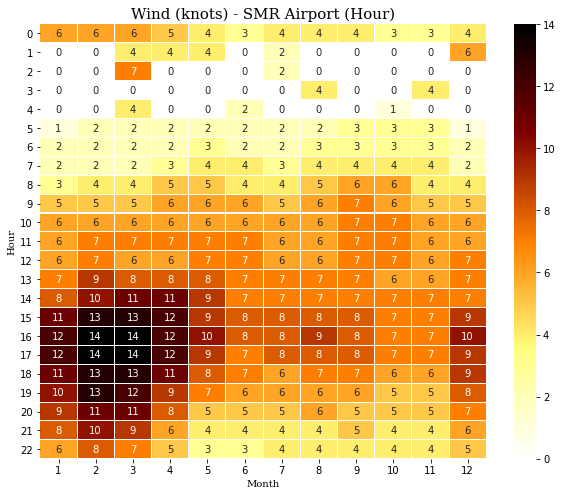

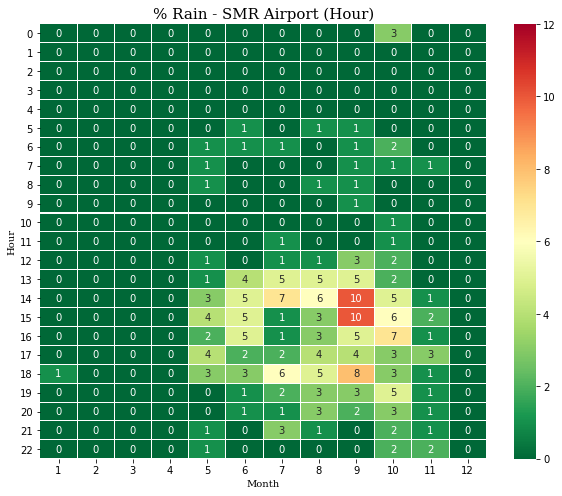

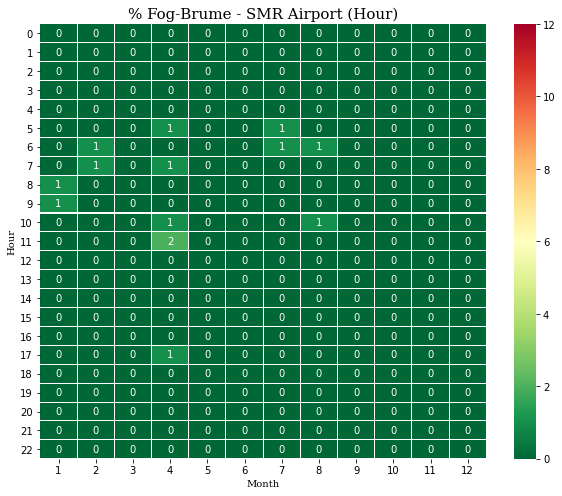

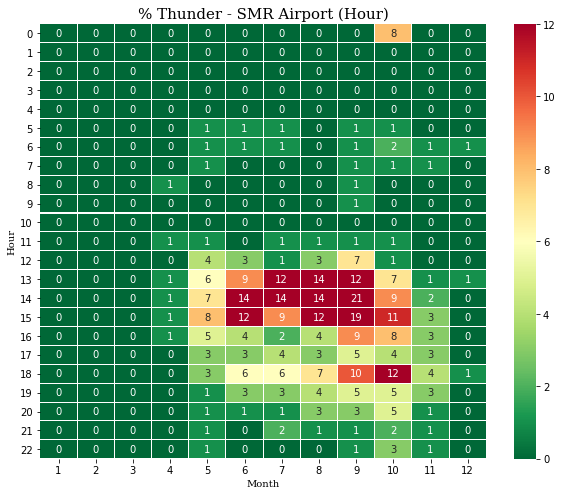

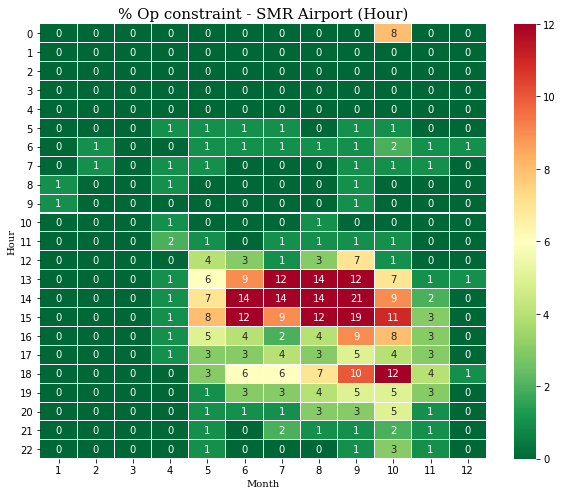

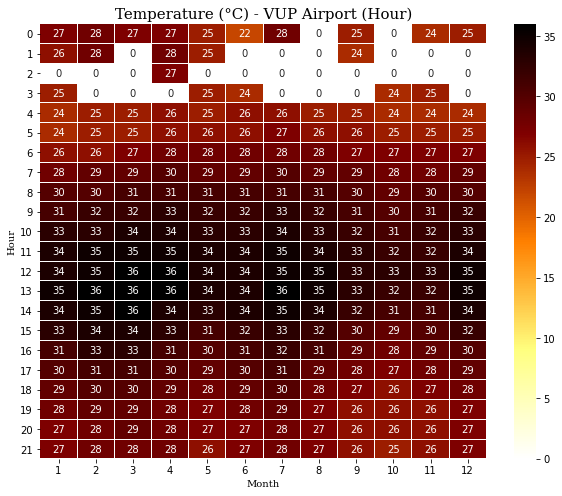

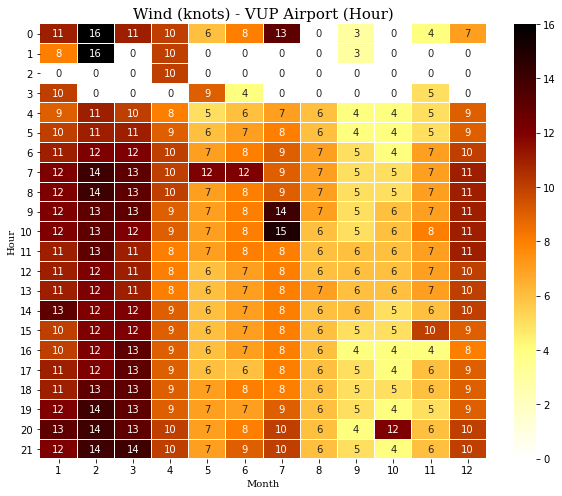

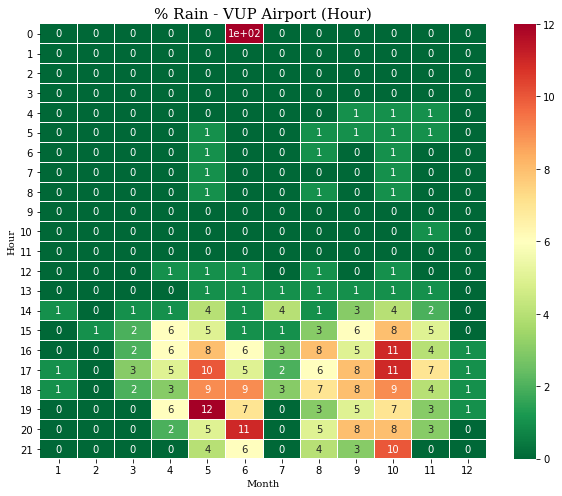

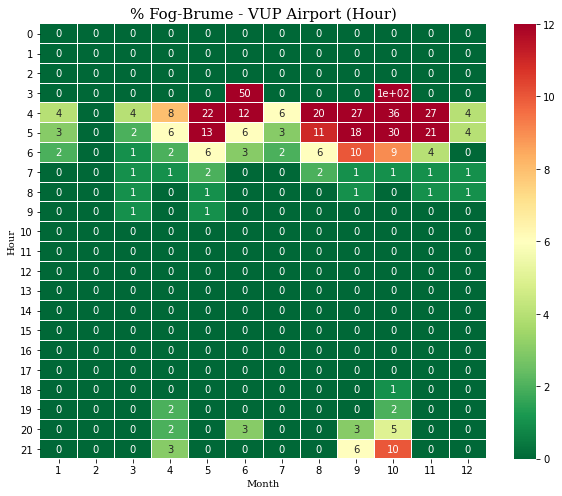

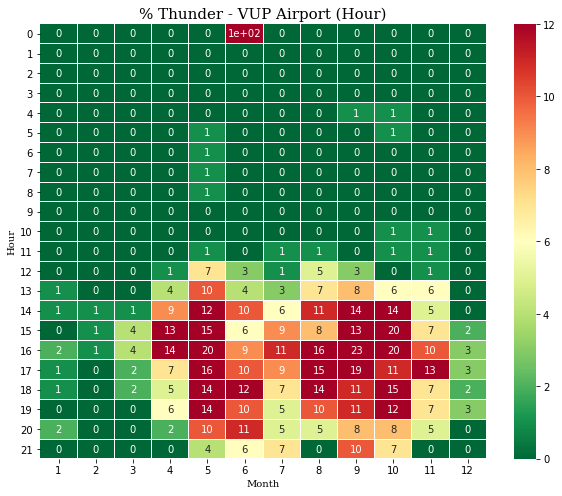

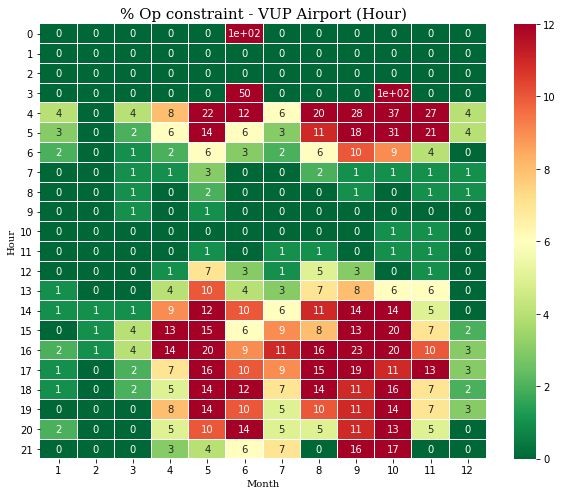

In [15]:
#Generate and Save Heatmpas by airport

vmin=0
vmax=12
ax={}
f={}

for i in request:
    if Save_heatmaps==True:
        dir2=str(dir)+"/"+str(i)
        print(dir2)
        if os.path.exists(dir2):
            shutil.rmtree(dir2)
        os.makedirs(dir2)
    for j in hour:
        for k in columns:
            ax[(i,j,k)]= plt.figure(figsize=(10, 8))
            if k=="Temperature" or k=="Wind":
                ax[(i,j,k)]=sns.heatmap(group.get((i,j,k)),cmap="afmhot_r",annot=True,linewidths=.01)
            else:
                ax[(i,j,k)]=sns.heatmap(group.get((i,j,k)),vmin=vmin, vmax=vmax,cmap="RdYlGn_r",annot=True,linewidths=.01)
            
            ax[(i,j,k)].set_yticklabels(np.arange(0,24))
            ax[(i,j,k)].set_ylabel(j,fontsize=10,family="serif")
            ax[(i,j,k)].set_xlabel("Month",fontsize=10,family="serif")
            ax[(i,j,k)].set_title(columns_title[columns.index(k)]+" - "+ i +" Airport ("+j.replace("Hour ","")+")",fontsize=15,family="serif")
            
            if Save_heatmaps==True:
                my_file=j.replace("Hour ","")+" "+columns_title[columns.index(k)]+" - "+ i +" Airport"+'.png'
                plt.savefig(os.path.join(dir2, my_file))  


In [16]:
#Merge historical visibility information & Airport Type & targets
data=pd.merge(data,Fog,how='left',on=['IATA','Month','Hour'])

data=pd.merge(data,airports['Airport Type'],how='left',left_on=['IATA'],right_index=True)

data=pd.merge(data,minimos,how="left",left_on=['IATA'],right_index=True)

#Dummies
data=pd.concat([data,pd.get_dummies(data['Airport Type'],prefix="Airport Type")],axis=1)
data.drop(columns=['Airport Type'],inplace=True)

data.head()

IATA  OACI                Date  Year  Month  Day  Hour  H Vsby  V Vsby  \
0  ADZ  SKSP 2015-01-01 00:00:00  2015      1    1     0    6.21  1700.0   
1  ADZ  SKSP 2015-01-01 01:00:00  2015      1    1     1    6.21  1700.0   
2  ADZ  SKSP 2015-01-01 02:00:00  2015      1    1     2    6.21  1700.0   
3  ADZ  SKSP 2015-01-01 03:00:00  2015      1    1     3    6.21  1700.0   
4  ADZ  SKSP 2015-01-01 04:00:00  2015      1    1     4    6.21  1700.0   

   Temperature  Wind  Rain  Fog-Brume  Thunder  Op constraint  \
0         27.0   9.0     0          0        0              0   
1         27.0   9.0     0          0        0              0   
2         27.0   8.0     0          0        0              0   
3         27.0   8.0     0          0        0              0   
4         27.0   8.0     0          0        0              0   

   % Fog Occurence  H Vsby (miles)  V Vsby (ft)  Airport Type_0  \
0              0.0            1.43          500               1   
1              1.0            1.43          500               1   
2              0.0            1.43          500               1   
3              0.0            1.43          500               1   
4              0.0            1.43          500               1   

   Airport Type_1  Airport Type_2  
0               0               0  
1               0               0  
2               0               0  
3               0               0  
4               0               0

In [17]:
data['Avaliable H Vsby']=data['H Vsby']-data['H Vsby (miles)']
data['Avaliable H Vsby']=[1 if x>0 else 0 for x in data['Avaliable H Vsby']]

data['Avaliable V Vsby']=data['V Vsby']-data['V Vsby (ft)']
data['Avaliable V Vsby']=[1 if x>0 else 0 for x in data['Avaliable V Vsby']]

data.head()

IATA  OACI                Date  Year  Month  Day  Hour  H Vsby  V Vsby  \
0  ADZ  SKSP 2015-01-01 00:00:00  2015      1    1     0    6.21  1700.0   
1  ADZ  SKSP 2015-01-01 01:00:00  2015      1    1     1    6.21  1700.0   
2  ADZ  SKSP 2015-01-01 02:00:00  2015      1    1     2    6.21  1700.0   
3  ADZ  SKSP 2015-01-01 03:00:00  2015      1    1     3    6.21  1700.0   
4  ADZ  SKSP 2015-01-01 04:00:00  2015      1    1     4    6.21  1700.0   

   Temperature  Wind  Rain  Fog-Brume  Thunder  Op constraint  \
0         27.0   9.0     0          0        0              0   
1         27.0   9.0     0          0        0              0   
2         27.0   8.0     0          0        0              0   
3         27.0   8.0     0          0        0              0   
4         27.0   8.0     0          0        0              0   

   % Fog Occurence  H Vsby (miles)  V Vsby (ft)  Airport Type_0  \
0              0.0            1.43          500               1   
1              1.0            1.43          500               1   
2              0.0            1.43          500               1   
3              0.0            1.43          500               1   
4              0.0            1.43          500               1   

   Airport Type_1  Airport Type_2  Avaliable H Vsby  Avaliable V Vsby  
0               0               0                 1                 1  
1               0               0                 1                 1  
2               0               0                 1                 1  
3               0               0                 1                 1  
4               0               0                 1                 1

In [18]:
#Borrar columnas de minimos meteorologicos y organizar columnas
data.columns

Index(['IATA', 'OACI', 'Date', 'Year', 'Month', 'Day', 'Hour', 'H Vsby',
       'V Vsby', 'Temperature', 'Wind', 'Rain', 'Fog-Brume', 'Thunder',
       'Op constraint', '% Fog Occurence', 'H Vsby (miles)', 'V Vsby (ft)',
       'Airport Type_0', 'Airport Type_1', 'Airport Type_2',
       'Avaliable H Vsby', 'Avaliable V Vsby'],
      dtype='object')

In [19]:
data=data[['IATA', 'OACI', 'Date', 'Year', 'Month', 'Day', 'Hour','Avaliable H Vsby', 'Avaliable V Vsby', 'H Vsby',
       'V Vsby', 'Temperature', 'Wind', 'Rain', 'Fog-Brume', 'Thunder', '% Fog Occurence'
           ,'Airport Type_0', 'Airport Type_1', 'Airport Type_2']]

In [20]:
#Check missing data

missing_data = data.isnull()

for column in data.columns[data.isnull().any()].tolist():
    print (missing_data[column].value_counts())

False    604409
True       1293
Name: H Vsby, dtype: int64
False    567311
True      38391
Name: V Vsby, dtype: int64
False    604353
True       1349
Name: Temperature, dtype: int64
False    604708
True        994
Name: Wind, dtype: int64


In [21]:
#imputacion de datos
#https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group

data['H Vsby'] = data[['IATA','H Vsby']].groupby("IATA").transform(lambda x: x.fillna(x.mean()))
data['V Vsby'] = data[['IATA','V Vsby']].groupby("IATA").transform(lambda x: x.fillna(x.mean()))
data['Temperature'] = data[['IATA','Temperature']].groupby("IATA").transform(lambda x: x.fillna(x.mean()))
data['Wind'] = data[['IATA','Wind']].groupby("IATA").transform(lambda x: x.fillna(x.mean()))


In [22]:
#Check missing data

missing_data = data.isnull()

for column in data.columns[data.isnull().any()].tolist():
    print (missing_data[column].value_counts())

In [23]:
#Crear columnas de la historia meteorologica

columns=['IATA','H Vsby','V Vsby','Temperature','Wind']
t=3

for j in range(1,t+1):
    for i in columns:
        data[i+" t-"+str(j)]=data[i].shift(j)
    
    data=data[data['IATA']==data['IATA t-'+str(j)]]
    data.drop(columns=['IATA t-'+str(j)],inplace=True)

data.reset_index(drop=True,inplace=True)
data.head()      

IATA  OACI                Date  Year  Month  Day  Hour  Avaliable H Vsby  \
0  ADZ  SKSP 2015-01-01 07:00:00  2015      1    1     7                 1   
1  ADZ  SKSP 2015-01-01 08:00:00  2015      1    1     8                 1   
2  ADZ  SKSP 2015-01-01 09:00:00  2015      1    1     9                 1   
3  ADZ  SKSP 2015-01-01 10:00:00  2015      1    1    10                 1   
4  ADZ  SKSP 2015-01-01 11:00:00  2015      1    1    11                 1   

   Avaliable V Vsby  H Vsby  V Vsby  Temperature  Wind  Rain  Fog-Brume  \
0                 1    6.21  1700.0         27.0   9.0     0          0   
1                 1    6.21  1700.0         28.0   8.0     0          0   
2                 1    6.21  1700.0         28.0  10.0     0          0   
3                 1    6.21  1700.0         29.0  11.0     0          0   
4                 1    6.21  1700.0         29.0  11.0     0          0   

   Thunder  % Fog Occurence  Airport Type_0  Airport Type_1  Airport Type_2  \
0        0              1.0               1               0               0   
1        0              0.0               1               0               0   
2        0              0.0               1               0               0   
3        0              0.0               1               0               0   
4        0              0.0               1               0               0   

   H Vsby t-1  V Vsby t-1  Temperature t-1  Wind t-1  H Vsby t-2  V Vsby t-2  \
0        6.21      1700.0             27.0       9.0        6.21      1700.0   
1        6.21      1700.0             27.0       9.0        6.21      1700.0   
2        6.21      1700.0             28.0       8.0        6.21      1700.0   
3        6.21      1700.0             28.0      10.0        6.21      1700.0   
4        6.21      1700.0             29.0      11.0        6.21      1700.0   

   Temperature t-2  Wind t-2  H Vsby t-3  V Vsby t-3  Temperature t-3  \
0             27.0       8.0        6.21      1700.0             27.0   
1             27.0       9.0        6.21      1700.0             27.0   
2             27.0       9.0        6.21      1700.0             27.0   
3             28.0       8.0        6.21      1700.0             27.0   
4             28.0      10.0        6.21      1700.0             28.0   

   Wind t-3  
0       8.0  
1       8.0  
2       9.0  
3       9.0  
4       8.0

In [24]:
#Check missing data

missing_data = data.isnull()

for column in data.columns[data.isnull().any()].tolist():
    print (missing_data[column].value_counts())

In [25]:
#HAce falta crear una variable binaria que diga si el Aeropuerto esta disponible operacionalmente, tener en cuenta las columnas
#Avaliable H Vsby & Avaliable V Vsby si alguna de ellas es 0 el aeropuerto no esta operativo

X=data.iloc[:,11:]

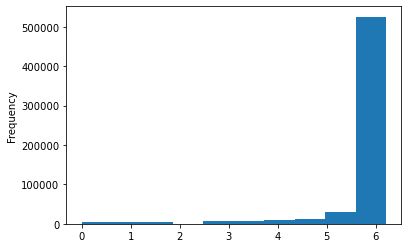

In [26]:
data['H Vsby'].plot.hist()

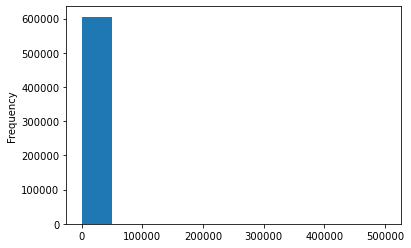

In [27]:
data['V Vsby'].plot.hist()

In [28]:
#Hace falta limpiar outliers
#Crear un filtro de data frame donde solo se tenga en cuenta solo la información menor a 9999 para Visibilidad vertical

## Time Series Forecasting

In [29]:
#The user should modify manually the IATA codes for the specifics airports that will be modeled
Airports=['ADZ','BAQ','BOG','BGA','CLO','CTG','CUC','LET','MDE','MTR','PEI','RCH','SMR','VUP']
#Airports=['BOG']
Variables=['V Vsby', 'H Vsby']

184/184 [==============================] - 0s 3ms/step - loss: 0.4583 - mean_absolute_error: 0.2871


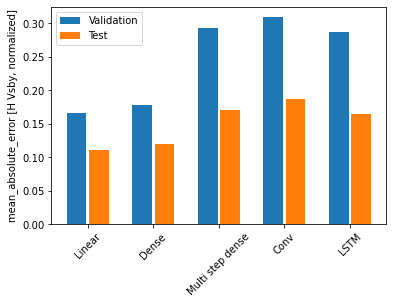

In [30]:
for j in range (0,len(Variables)):
    Variable=Variables[j]
    val_performance = {}
    performance = {}

###################### Loop to go across the airports of interest ############################################## 
    for i in range (0,len(Airports)):
        Airport=Airports[i]
        val_performance = {}
        performance = {}

###################### Manipulates and Normalizes the data ################################################### 

#Generates a new Dataset, containing only the airport code and the numeric variables regarding the metereological variables
        data_forecasting=data[['IATA','H Vsby','V Vsby', 'Temperature', 'Wind', 'Rain', 'Fog-Brume', 'Thunder', '% Fog Occurence']]

#Generates a Function to filter the dataset only for the specific airport that will be modeled
        def data_airport(str_airport):
            df_airport_2=data_forecasting[data_forecasting['IATA']==str_airport]    
            return df_airport_2

#Names the new data set df and drops the IATA code column, as it will not be included in the model
        df=data_airport(Airport)

        df.drop('IATA',
          axis='columns', inplace=True)


# Splits the data in Training, Validation and Test with a 0.7, 0.1 and 0.2 percentages
        column_indices = {name: i for i, name in enumerate(df.columns)}
        n = len(df)
        train_df = df[0:int(n*0.7)]
        val_df = df[int(n*0.7):int(n*0.9)]
        test_df = df[int(n*0.9):]


#Defines the number of features that will be included in  the model, as the total number of columns in the new df
        num_features = df.shape[1]

#Normalizes the 3 datasets, taking into account the training dataset mean and std
        train_mean = train_df.mean()
        train_std = train_df.std()

        train_df = (train_df - train_mean) / train_std
        val_df = (val_df - train_mean) / train_std
        test_df = (test_df - train_mean) / train_std



################ Defines the classes and Functions that will be used to build the Models ###########################


#Generates the class WindowGenerator, that will help defining the timestep that will be used in the model
        class WindowGenerator():
    #The first function within the class is to instantiate and define the variables entered as input
          def __init__(self, input_width, label_width, shift,
                       train_df=train_df, val_df=val_df, test_df=test_df,
                       label_columns=None):
    # Stores the raw data from the dataset
            self.train_df = train_df
            self.val_df = val_df
            self.test_df = test_df
    
    # Work out the label and the column indices, depending on the input parameters
            self.label_columns = label_columns
            if label_columns is not None:
              self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                                   enumerate(train_df.columns)}

    # Work out the window parameters.
            self.input_width = input_width
            self.label_width = label_width
            self.shift = shift

            self.total_window_size = input_width + shift

            self.input_slice = slice(0, input_width)
            self.input_indices = np.arange(self.total_window_size)[self.input_slice]

            self.label_start = self.total_window_size - self.label_width
            self.labels_slice = slice(self.label_start, None)
            self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    #This functions returns the Total Window Size, the Input and Label Indices and the Label column name
          def __repr__(self):
            return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'])


#Defines a function to split the data sets according to the Window Type defined previously
        def split_window(self, features):
    #The input variables will be those that will not be predicted
          inputs = features[:, self.input_slice, :]
    #The label variables will be those that will be predicted
          labels = features[:, self.labels_slice, :]
          if self.label_columns is not None:
        #In case there is more than one label variable, this for stacks all of them
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

    #Defines the shapes for the input and the label variables
          inputs.set_shape([None, self.input_width, None])
          labels.set_shape([None, self.label_width, None])

    #Returns the input and the labels  
          return inputs, labels

        WindowGenerator.split_window = split_window



#Plot Function
        def plot(self, model=None, plot_col=Variable, max_subplots=3):
#Defines the input and the label variables
          inputs, labels = self.example
#Defines the plot size, plotting columns and maximum number of subplots that will be displayed
          plt.figure(figsize=(12, 8))
          plot_col_index = self.column_indices[plot_col]
          max_n = min(max_subplots, len(inputs))
#Plots a line with the measures for the label variable across the different timesteps
          for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue
#Plots a scatter with the exact measures for each timestep for the label variable
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
#If the is a model already defined, plots the predictions made for each timestep
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
              plt.legend()

          plt.xlabel('Time [h]')

        WindowGenerator.plot = plot


#This function will create the dataset in the TF format
        def make_dataset(self, data):
#Starting from a Pandas df, it converts it to a Numpy array of type float32
          data = np.array(data, dtype=np.float32)
#Uses the method tf.keras.preprocessing.timeseries_dataset_from_array to convert from np array to tf dataset
          ds = tf.keras.preprocessing.timeseries_dataset_from_array(
#The data will be the one inputed as a parameter in the function
              data=data,
# No Target defined
              targets=None,
#Defines the sequence lenght as the Total size of the Window 
              sequence_length=self.total_window_size,
#Defines the time between timestep as 1      
              sequence_stride=1,
#Defines to shuffle the output samples, intead of showing them in chronological order
              shuffle=True,
#Defines the batch that will be used to run the model. The predefined Batch will be 32. The last one will
#probably not be the same size
              batch_size=32,)
#Retunrs a mapping of the tf dataset generated
          ds = ds.map(self.split_window)

          return ds
        WindowGenerator.make_dataset = make_dataset


#Defines as properties of the Class, Functions for generating the Trainig, Validation and Test datasets 
#using the make_dataset function
        @property
        def train(self):
          return self.make_dataset(self.train_df)

        @property
        def val(self):
          return self.make_dataset(self.val_df)

        @property
        def test(self):
          return self.make_dataset(self.test_df)

#Gives this for using it as an example dataset, in case you don want to generate a subset of the previous dataframes
#In this case, the example will be used for plotting a random Window from the training dataset
        @property
        def example(self):
          """Get and cache an example batch of `inputs, labels` for plotting."""
          result = getattr(self, '_example', None)
          if result is None:
    # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
    # And cache it for next time
            self._example = result
          return result

        WindowGenerator.train = train
        WindowGenerator.val = val
        WindowGenerator.test = test
        WindowGenerator.example = example


####################### Windowing for the Models ###############################################################

#Defines a simple Window, correspondig to a 1 Input and 1 Label variable.
#Defines the Label Variable, depending on the Variable defined at the begging of the analysis

        single_step_window = WindowGenerator(
            input_width=1, label_width=2, shift=1,
            label_columns=[Variable])
        single_step_window

#Generates a new, Wider Window correponding to a 24 Hours period, with a label widht of 24 hours and 1 
#and 1 timestep as Shift
        wide_window = WindowGenerator(
            input_width=24, label_width=24, shift=1,
            label_columns=[Variable])

################################## Linear Model ####################################################################
        linear = tf.keras.Sequential([
            tf.keras.layers.Dense(units=1)
        ])

#Defines the Max Number of Epochs for the model as 20
        MAX_EPOCHS = 20

#Defines a generic funtion of Compiling and Fiting the model. It is define so, that
#it can be used for any type of model. The inputs will be the model to compile and fit, the Window used and the
#Patience parameter for the Earlt Stop callback from keras
        def compile_and_fit(model, window, patience=2):
#Defines the Early Stopping to avoid Overfitting
          early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=patience,
                                                            mode='min')
#Compiles the model
          model.compile(loss=tf.losses.MeanSquaredError(),
                        optimizer=tf.optimizers.Adam(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

#Fits the model and stores the data in an objet called history
          history = model.fit(window.train, epochs=MAX_EPOCHS,
                              validation_data=window.val,
                              callbacks=[early_stopping])
          return history

        print('Linear Model:')
#Compiles and Fits the linear model with the single step window
        history = compile_and_fit(linear, single_step_window)

        import IPython
#Deletes the results for the 20 Epochs and only sisplays the last Epoch result
        IPython.display.clear_output()

#Stores in the Variables the Performance for the Validation and the Test Performance
        val_performance['Linear'] = linear.evaluate(single_step_window.val)
        performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


###################### Dense #####################################################################################

#Defines the Dense Model and Compiles and Fit for the Single Step WIndow
#The Dense model defines 2 intermediate layers with 64 neurons each, with a relu activation function

        dense = tf.keras.Sequential([
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])

        print('Dense Model:')
#Compiles and fits the model
        history = compile_and_fit(dense, single_step_window)

#Deletes the results for the 20 Epochs and only sisplays the last Epoch result
        IPython.display.clear_output()

#Stores the performances
        val_performance['Dense'] = dense.evaluate(single_step_window.val)
        performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


################# Multi Step Model##############################################################################

#The previous Models predicts the following hour, taking into account only the previous hour. in this Model
#You can define the number of previous hours that the model will take into account for predicting. In this case, 3
        CONV_WIDTH = 3

#Defines a new Window depending on the new step defined
        conv_window = WindowGenerator(
            input_width=CONV_WIDTH,
            label_width=1,
            shift=1,
            label_columns=[Variable])

        conv_window

#Define the new model as the dense model, but with the new Step
        multi_step_dense = tf.keras.Sequential([
            # Shape: (time, features) => (time*features)
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=1),
            # Add back the time dimension.
            # Shape: (outputs) => (1, outputs)
            tf.keras.layers.Reshape([1, -1]),
        ])

        print('Dense Multi Step Model:')
#Compiles and fits the new Model
        history = compile_and_fit(multi_step_dense, conv_window)

#Deletes the results for the 20 Epochs and only Displays the last Epoch result
        IPython.display.clear_output()
#Stores the performances
        val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
        performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)



#################################Convolutional Model##############################################################

#Defines the new model including a Convolutional layer, which allows to inlude the the new Window for he prediction
#The first advantage is that now it is not necesarry to predict only using the last timestep
        conv_model = tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters=32,
                                   kernel_size=(CONV_WIDTH,),
                                   activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=1),
        ])


        print('Convolutional Model:')
#Trains and Compiles the new model
        history = compile_and_fit(conv_model, conv_window)

#Cleans the results and store the performances
        IPython.display.clear_output()
        val_performance['Conv'] = conv_model.evaluate(conv_window.val)
        performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

#Generates new Windows according to the inputs required by the Convolutional model
        LABEL_WIDTH = 24
        INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
        wide_conv_window = WindowGenerator(
            input_width=INPUT_WIDTH,
            label_width=LABEL_WIDTH,
            shift=1,
            label_columns=[Variable])


##############################Recurrent Neural Model##############################################################

#Defines the new model with a recurrent layer. This models uses the results of each time step to retrofit the following 
#prediction
        lstm_model = tf.keras.models.Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(32, return_sequences=True),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1)
        ])

        print('Recurrent Model:')
#Compiles and fits the new model
        history = compile_and_fit(lstm_model, wide_window)

#Cleans and stores the performances
        IPython.display.clear_output()
        val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
        performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


####################Evaluates the performance for all the models with the normlized measures#######################

        x = np.arange(len(performance))
        width = 0.3
        metric_name = 'mean_absolute_error'
        metric_index = lstm_model.metrics_names.index('mean_absolute_error')
        val_mae = [v[metric_index] for v in val_performance.values()]
        test_mae = [v[metric_index] for v in performance.values()]

        ylabel_plot='mean_absolute_error ['+Variable+', normalized]'
        plt.ylabel(ylabel_plot)
        plt.bar(x - 0.17, val_mae, width, label='Validation')
        plt.bar(x + 0.17, test_mae, width, label='Test')
        plt.xticks(ticks=x, labels=performance.keys(),
                   rotation=45)
        _ = plt.legend()
        plt.show()

########################### Saves the Performance Array and Plots ########################################################
        from datetime import datetime
        now = datetime.now() # current date and time
        year = now.strftime("%Y")
        year_0=year[0]
        year_1=year[1]
        year=year_0+year_1
        month = now.strftime("%m")
        day = now.strftime("%d")
        date_path=year+month+day
        date_path
        
        path_Performance=date_path+' Performance/'
    
        import os
        if not os.path.exists(path_Performance):
            os.makedirs(path_Performance)
        if not os.path.exists(path_Performance+Airport+'/'):
            os.makedirs(path_Performance+Airport+'/')
        
        import csv
        performance_name=path_Performance+Airport+'/'+Variable+'.csv'
        with open(performance_name, 'w') as f:
            for key in performance.keys():
                f.write("%s,%s\n"%(key,performance[key]))


########################### Saves the best Performed Model ########################################################
        
        path_Models=date_path+' Models/'
    
        if not os.path.exists(path_Models):
            os.makedirs(path_Models)
        if not os.path.exists(path_Models+Airport+'/'):
            os.makedirs(path_Models+Airport+'/')

        Best_Model=min(performance, key=performance.get)
        model_name=path_Models+Airport+'/'+Variable+'_'+Best_Model+'.h5'


        if Best_Model=='Linear':
            linear.save(model_name)
        elif Best_Model=='Dense':
            dense.save(model_name)
        elif Best_Model == 'Multi step dense':
            multi_step_dense.save(model_name)
        elif Best_Model == 'Conv':
            conv_model.save(model_name)
        else:
            lstm_model.save(model_name)